In [96]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import pickle
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from jcopml.utils import save_model, load_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

In [97]:
# Load the dataset
df = pd.read_csv('Data_XGBoost.csv',sep=';')
df

minute_timestamp  Pac_pvlib  solarRad  outsideTemp  outsideHumidity  \
0       01/09/2022 00:00        0.0         0         20.5               91   
1       01/09/2022 00:01        0.0         0         20.5               91   
2       01/09/2022 00:02        0.0         0         20.5               91   
3       01/09/2022 00:03        0.0         0         20.5               91   
4       01/09/2022 00:04        0.0         0         20.5               91   
...                  ...        ...       ...          ...              ...   
525595  31/08/2023 23:55        0.0         0         21.1               91   
525596  31/08/2023 23:56        0.0         0         21.1               91   
525597  31/08/2023 23:57        0.0         0         21.1               91   
525598  31/08/2023 23:58        0.0         0         21.1               91   
525599  31/08/2023 23:59        0.0         0         21.1               91   

        windSpeed  solar_azimuth  Pac Op_GriSwStt  GridMs_Hz  cos_theta  
0             0.0  -9.340480e-16    0    Grid-tie      48.99        0.0  
1             0.0  -3.327930e-02    0    Grid-tie      48.99        0.0  
2             0.0  -6.655790e-02    0    Grid-tie      48.99        0.0  
3             0.0  -9.983514e-02    0    Grid-tie      48.99        0.0  
4             0.0  -1.331103e-01    0    Grid-tie      48.99        0.0  
...           ...            ...  ...         ...        ...        ...  
525595        0.0  -3.126422e-01    0    Grid-tie      48.99        0.0  
525596        0.0  -2.501212e-01    0    Grid-tie      48.99        0.0  
525597        0.0  -1.875952e-01    0    Grid-tie      48.99        0.0  
525598        0.0  -1.250655e-01    0    Grid-tie      48.99        0.0  
525599        0.0  -6.253337e-02    0    Grid-tie      48.99        0.0  

[525600 rows x 11 columns]

In [98]:
# Check for null values
df.isna().sum()

minute_timestamp    0
Pac_pvlib           0
solarRad            0
outsideTemp         0
outsideHumidity     0
windSpeed           0
solar_azimuth       0
Pac                 0
Op_GriSwStt         0
GridMs_Hz           0
cos_theta           0
dtype: int64

In [99]:
# Periksa nilai unik dalam kolom 'Op_GriSwStt'
print(df['Op_GriSwStt'].unique())

['Grid-tie' 'Isolated']


In [100]:
# Hitung jumlah baris dengan nilai Pac tidak nol untuk setiap status operasional
open_nonzero_pac_count = df[(df['Op_GriSwStt'] == 'Grid-tie') & (df['Pac'] != 0)].shape[0]
closed_nonzero_pac_count = df[(df['Op_GriSwStt'] == 'Isolated') & (df['Pac'] != 0)].shape[0]

print("Jumlah baris dengan Pac tidak nol saat status operasional Grid-tie:", open_nonzero_pac_count)
print("Jumlah baris dengan Pac tidak nol saat status operasional Isolated:", closed_nonzero_pac_count)


Jumlah baris dengan Pac tidak nol saat status operasional Grid-tie: 71993
Jumlah baris dengan Pac tidak nol saat status operasional Isolated: 168652


In [101]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Op_GriSwStt'] = label_encoder.fit_transform(df['Op_GriSwStt'])


In [102]:
# Periksa nilai unik dalam kolom 'Op_GriSwStt'
print(df['Op_GriSwStt'].unique())

[0 1]


In [103]:
import time

# Mulai waktu
start_time = time.time()

df = df.set_index('minute_timestamp')
df.index = pd.to_datetime(df.index)

# Hitung waktu yang dibutuhkan
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Elapsed time: 129.48938250541687 seconds


In [104]:
# Create time series features
def create_features(df):
    df['month'] = df.index.month
    df['year'] = df.index.dayofyear
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['second'] = df.index.day

    return df

df = create_features(df)

In [105]:
# Split the data into training and testing sets
split_date1 = '2023-04-30 23:59:00'
split_date2 = '2023-06-30 23:59:00'
train = df.loc[df.index <= split_date1].copy()
test = df.loc[(df.index > split_date1)&(df.index < split_date2)].copy()
validasi = df.loc[(df.index > split_date2) &(df.index < '2023-08-31 23:59:00')].copy()

In [106]:
# Training set untuk regresi
X_train_reg = train.drop(columns=['Pac'])
y_train_reg = train['Pac']

# Test set untuk regresi
X_test_reg = test.drop(columns=['Pac'])
y_test_reg = test['Pac']

# Training set untuk klasifikasi
X_train_clf = train.drop(columns=['Op_GriSwStt'])
y_train_clf = train['Op_GriSwStt']

# Test set untuk klasifikasi
X_test_clf = test.drop(columns=['Op_GriSwStt'])
y_test_clf = test['Op_GriSwStt']

# Test set untuk regresi
X_validasi_reg = test.drop(columns=['Pac'])
y_validasi_reg = test['Pac']

# Test set untuk klasifikasi
X_validasi_clf = test.drop(columns=['Op_GriSwStt'])
y_validasi_clf = test['Op_GriSwStt']


In [107]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
import xgboost as xgb
from jcopml.tuning import random_search_params as rsp
from sklearn.pipeline import Pipeline, FeatureUnion
from xgboost import XGBRegressor, XGBClassifier


In [108]:
X_train_reg.columns

Index(['Pac_pvlib', 'solarRad', 'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth', 'Op_GriSwStt', 'GridMs_Hz', 'cos_theta', 'month',
       'year', 'day', 'hour', 'minute', 'second'],
      dtype='object')

# Lambda =0.15

In [109]:
# Ganti nilai-nilai ini sesuai dengan dataset Anda
Area_PV_train = 1.306788
solarRad_train = train['solarRad'].values
outsideTemp_train = train['outsideTemp'].values
efic_pv_train = 0.1544
number_of_module_train = 32
beta_train = 0.005
Ta_train = 25
lambda_val_train = 0.1

In [127]:
class CustomObjective():
    def __init__(self, Area_PV, solarRad, efic_pv, outsideTemp, number_of_module, beta, Ta, lambda_val):
        self.Area_PV = Area_PV
        self.solarRad = solarRad
        self.efic_pv = efic_pv
        self.outsideTemp = outsideTemp
        self.number_of_module = number_of_module
        self.beta = beta
        self.Ta = Ta
        self.lambda_val = lambda_val

    def loss(self, y_true, y_pred):
        # Sesuaikan dengan rumus loss Anda
        loss = 1/2 * self.lambda_val * (((self.Area_PV * self.solarRad * self.efic_pv *(1- self.beta *(self.outsideTemp-self.Ta)))- y_pred) ** 2) + 1/2 *((y_true - y_pred) ** 2)         
        return np.mean(loss)

    def gradient(self, y_true, y_pred):
        # Sesuaikan dengan rumus gradien Anda
        gradient = -self.lambda_val * ((self.Area_PV * self.solarRad * self.efic_pv *(1- self.beta *(self.outsideTemp-self.Ta)))- y_pred) - (y_true - y_pred)
        return gradient

    def hessian(self, y_true, y_pred):
        # Sesuaikan dengan rumus hessian Anda
        hessian = np.ones(len(y_true))
        return hessian
    
    
    
import pickle

# Define the lambda function outside the __init__ method
def default_param():
    return None

class XGBoostModel():
    '''XGBoost from Scratch
    '''
    
    def __init__(self, params, random_seed=None):
        self.params = defaultdict(default_param, params)
        self.subsample = self.params['subsample'] \
            if self.params['subsample'] else 1.0
        self.learning_rate = self.params['learning_rate'] \
            if self.params['learning_rate'] else 0.3
        self.base_prediction = self.params['base_score'] \
            if self.params['base_score'] else 0.5
        self.max_depth = self.params['max_depth'] \
            if self.params['max_depth'] else 5
        self.rng = np.random.default_rng(seed=random_seed)
        self.boosters = []  # Tambahkan inisialisasi boosters
        self.interaction_constraints = None  # Tambahkan variabel untuk interaction_constraints

    def fit(self, X, y, objective, num_boost_round, verbose=False, interaction_constraints=None):
        self.interaction_constraints = interaction_constraints  # Tambahkan pengaturan interaction_constraints
        current_predictions = self.base_prediction * np.ones(shape=y.shape)
        result_array = [[0 for _ in range(num_boost_round)] for _ in range(2)]
        for i in range(num_boost_round):
            gradients = objective.gradient(y, current_predictions)
            hessians = objective.hessian(y, current_predictions)
            sample_idxs = None if self.subsample == 1.0 \
                else self.rng.choice(len(y), 
                                     size=math.floor(self.subsample*len(y)), 
                                     replace=False)
            booster = TreeBooster(X, gradients, hessians, 
                                  self.params, self.max_depth, sample_idxs, self.interaction_constraints)
            current_predictions += self.learning_rate * booster.predict(X)
            self.boosters.append(booster)
            if verbose: 
                loss_value = objective.loss(y, current_predictions)
                gradient_value = gradients.iloc[0]
                result_array[0][i] = loss_value
                result_array[1][i] = gradient_value
                print(f'[{i}] train loss = {loss_value}, gradient (data point ) = {gradient_value}')
        
        return result_array

    def predict(self, X):
        predictions = self.base_prediction + self.learning_rate * np.sum([booster.predict(X) for booster in self.boosters], axis=0)
        return self.clip_predictions(predictions, X['solarRad'].values)

    def clip_predictions(self, predictions, solarRad):
        predictions = np.maximum(predictions, 0)
        predictions[solarRad == 0] = 0
        return predictions

    
    def save_model(self, file_path):
        with open(file_path, 'wb') as file:
            pickle.dump(self, file)

class TreeBooster():
    def __init__(self, X, g, h, params, max_depth, idxs=None, interaction_constraints=None):
        self.params = params
        self.max_depth = max_depth
        assert self.max_depth >= 0, 'max_depth must be nonnegative'
        self.min_child_weight = params['min_child_weight'] if params['min_child_weight'] else 1.0
        self.reg_lambda = params['reg_lambda'] if params['reg_lambda'] else 1.0
        self.gamma = params['gamma'] if params['gamma'] else 0.0
        self.colsample_bynode = params['colsample_bynode'] if params['colsample_bynode'] else 1.0
        self.interaction_constraints = interaction_constraints  # Tambahkan variabel untuk interaction_constraints
        if isinstance(g, pd.Series): g = g.values
        if isinstance(h, pd.Series): h = h.values
        if idxs is None: idxs = np.arange(len(g))
        self.X, self.g, self.h, self.idxs = X, g, h, idxs
        self.n, self.c = len(idxs), X.shape[1]
        self.value = -g[idxs].sum() / (h[idxs].sum() + self.reg_lambda)
        self.best_score_so_far = 0.
        if self.max_depth > 0:
            self._maybe_insert_child_nodes()

    def _maybe_insert_child_nodes(self):
        for i in range(self.c): self._find_better_split(i)
        if self.is_leaf: return
        x = self.X.values[self.idxs,self.split_feature_idx]
        left_idx = np.nonzero(x <= self.threshold)[0]
        right_idx = np.nonzero(x > self.threshold)[0]
        self.left = TreeBooster(self.X, self.g, self.h, self.params, 
                                self.max_depth - 1, self.idxs[left_idx])
        self.right = TreeBooster(self.X, self.g, self.h, self.params, 
                                 self.max_depth - 1, self.idxs[right_idx])

    @property
    def is_leaf(self): return self.best_score_so_far == 0.
    
    def _find_better_split(self, feature_idx):
        x = self.X.values[self.idxs, feature_idx]
        g, h = self.g[self.idxs], self.h[self.idxs]
        sort_idx = np.argsort(x)
        sort_g, sort_h, sort_x = g[sort_idx], h[sort_idx], x[sort_idx]
        sum_g, sum_h = g.sum(), h.sum()
        sum_g_right, sum_h_right = sum_g, sum_h
        sum_g_left, sum_h_left = 0., 0.

        for i in range(0, self.n - 1):
            g_i, h_i, x_i, x_i_next = sort_g[i], sort_h[i], sort_x[i], sort_x[i + 1]
            sum_g_left += g_i; sum_g_right -= g_i
            sum_h_left += h_i; sum_h_right -= h_i
            if sum_h_left < self.min_child_weight or x_i == x_i_next:continue
            if sum_h_right < self.min_child_weight: break

            gain = 0.5 * ((sum_g_left**2 / (sum_h_left + self.reg_lambda))
                            + (sum_g_right**2 / (sum_h_right + self.reg_lambda))
                            - (sum_g**2 / (sum_h + self.reg_lambda))
                            ) - self.gamma/2
            if gain > self.best_score_so_far: 
                self.split_feature_idx = feature_idx
                self.best_score_so_far = gain
                self.threshold = (x_i + x_i_next) / 2
                
    def predict(self, X):
        return np.array([self._predict_row(row) for i, row in X.iterrows()])

    def _predict_row(self, row):
        if self.is_leaf: 
            return self.value
        child = self.left if row[self.split_feature_idx] <= self.threshold \
            else self.right
        return child._predict_row(row)

In [128]:
X_test_reg.columns

Index(['Pac_pvlib', 'solarRad', 'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth', 'Op_GriSwStt', 'GridMs_Hz', 'cos_theta', 'month',
       'year', 'day', 'hour', 'minute', 'second'],
      dtype='object')

In [ ]:
import time

# Mulai waktu
start_time = time.time()

# Fitur numerik untuk regresi
numeric_cols_reg = ['Pac_pvlib', 'solarRad', 'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth', 'GridMs_Hz', 'cos_theta', 'month',
       'year', 'day', 'hour', 'minute', 'second']

# Fitur kategorikal untuk regresi
categoric_cols_reg = ['Op_GriSwStt']

# Fitur numerik untuk klasifikasi
numeric_cols_clf = ['Pac_pvlib', 'solarRad', 'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth', 'GridMs_Hz', 'cos_theta', 'month',
       'year', 'day', 'hour', 'minute', 'second']

# Preprocessor untuk regresi
preprocessor_reg = ColumnTransformer([
    ('numeric', 'passthrough', numeric_cols_reg),
    ('categoric', OneHotEncoder(), categoric_cols_reg)
])

# Preprocessor untuk klasifikasi
preprocessor_clf = ColumnTransformer([
    ('numeric', 'passthrough', numeric_cols_clf)
])
# Pipeline untuk regresi
pipeline_reg = Pipeline([
    ('prep', preprocessor_reg),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

# Pipeline untuk klasifikasi
pipeline_clf = Pipeline([
    ('prep', preprocessor_clf),
    ('algo', XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42))
])
# Hyperparameter yang telah ditentukan sebelumnya
rsp = {
    'xgb_params': {
        'algo__max_depth': [3, 4, 5, 6, 7, 8],
        'algo__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'algo__n_estimators': [50, 100, 150, 200],
        'algo__gamma': [0, 1, 2, 3, 4],
        'algo__min_child_weight': [1, 2, 3, 4],
        'algo__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'algo__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'algo__reg_alpha': [0, 0.1, 0.5, 1],
        'algo__reg_lambda': [0, 0.1, 0.5, 1]
    }
}
num_boost_round = 25

# Determine whether to use the data for regression or classification based on 'Op_GriSwStt'
if 'Pac' in train.columns:
    # Regression
    X_train = train.drop(columns=['Pac'])
    y_train = train['Pac']
    X_test = test.drop(columns=['Pac'])
    y_test = test['Pac']
else:
    # Classification
    X_train = train.drop(columns=['Op_GriSwStt'])
    y_train = train['Op_GriSwStt']
    X_test = test.drop(columns=['Op_GriSwStt'])
    y_test = test['Op_GriSwStt']


custom_objective = CustomObjective(Area_PV_train, solarRad_train, efic_pv_train, outsideTemp_train, number_of_module_train, beta_train, Ta_train, lambda_val_train)

# Train the custom XGBoost model for regression
model_custom_reg = XGBoostModel(params=rsp['xgb_params'], random_seed=42)
model_custom_array = model_custom_reg.fit(X_train_reg, y_train_reg, custom_objective, num_boost_round=num_boost_round, verbose=True)

# Fit model for classification
model_clf = RandomizedSearchCV(pipeline_clf, rsp['xgb_params'], cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_clf.fit(X_train_clf, y_train_clf)# Hitung waktu yang dibutuhkan

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


[0] train loss = 50229.87774753718, gradient (data point ) = 0.55
[1] train loss = 28791.471031408782, gradient (data point ) = 0.4914974775447549
[2] train loss = 19028.922933128128, gradient (data point ) = 0.47896729164244645
[3] train loss = 14522.954557082303, gradient (data point ) = 0.48498167672939824
[4] train loss = 12456.644067495503, gradient (data point ) = 0.4565471046774498
[5] train loss = 11497.14720848874, gradient (data point ) = 0.3515788017134159
[6] train loss = 11046.042257490175, gradient (data point ) = 0.38164475436598244
[7] train loss = 10715.074804469677, gradient (data point ) = 0.19410061435511192
[8] train loss = 10531.592350447116, gradient (data point ) = 0.13709642519103316
[9] train loss = 10346.159762108882, gradient (data point ) = 0.1446822136201829
[10] train loss = 10258.461861020118, gradient (data point ) = 0.19637817026924137
[11] train loss = 10075.594444951808, gradient (data point ) = 0.08737539725702621
[12] train loss = 10028.23314560660

In [ ]:
# Mulai waktu
start_time = time.time()

# Predict Pac using the trained model
y_pred_reg = model_custom_reg.predict(X_test_reg)
# Predictions for classification
y_pred_clf = model_clf.predict(X_test_clf)

# Evaluate regression model
mse_reg = mean_squared_error(y_test_reg, y_pred_reg)
rmse_reg = np.sqrt(mse_reg)
r2_reg = r2_score(y_test_reg, y_pred_reg)
MAE_reg = mean_absolute_error(y_test_reg, y_pred_reg)
absolute_percentage_error_reg = np.abs((y_test_reg - y_pred_reg) / np.maximum(np.abs(y_test_reg), 1)) * 100
mape_reg = np.mean(np.where(np.isfinite(absolute_percentage_error_reg), absolute_percentage_error_reg, 0))

print('Regression Model Metrics:')
print('Mean Squared Error on Test Set: ', mse_reg)
print('Root Mean Squared Error on Test Set: ', rmse_reg)
print('R2 Score on Test Set: ', r2_reg)
print('Mean Absolute Error on Test Set: ', MAE_reg)
print('Mean Absolute Percentage Error on Test Set: ', mape_reg, '%')

# Print classification results
print("Classification Model Best Params:", model_clf.best_params_)
print("Classification Model Score:", model_clf.score(X_test_clf, y_test_clf))

# Evaluate classification model
accuracy_clf = accuracy_score(y_test_clf, y_pred_clf)
precision_clf = precision_score(y_test_clf, y_pred_clf)
recall_clf = recall_score(y_test_clf, y_pred_clf)
f1_clf = f1_score(y_test_clf, y_pred_clf)

print('Classification Model Metrics:')
print('Accuracy: ', accuracy_clf)
print('Precision: ', precision_clf)
print('Recall: ', recall_clf)
print('F1 Score: ', f1_clf)

# Compare Actual and Predicted Values for Classification
pd.DataFrame({"Actual": y_test_clf, "Predicted": y_pred_clf})[::1000]
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


In [ ]:
# Filter hasil prediksi regresi yang negatif
negative_predictions_reg = y_pred_reg[y_pred_reg < 0]

# Print hasil prediksi regresi yang negatif
print("Hasil Prediksi Regresi yang Negatif:", negative_predictions_reg)
# Hitung jumlah baris hasil prediksi regresi yang negatif
jumlah_baris_negatif_reg = negative_predictions_reg.shape[0]

# Print jumlah baris hasil prediksi regresi yang negatif
print("Jumlah Baris dengan Hasil Prediksi Regresi yang Negatif:", jumlah_baris_negatif_reg)


In [ ]:
from datetime import time

# Filter data untuk rentang waktu dari jam 18.02 sampai 05.30
filtered_df = predictions_df[
    ((predictions_df['Timestamp'].dt.hour == 19) & (predictions_df['Timestamp'].dt.minute >= 4)) |  # Jam 18:02 atau lebih
    (predictions_df['Timestamp'].dt.hour > 18) |  # Jam setelah 18:00
    ((predictions_df['Timestamp'].dt.hour == 4) & (predictions_df['Timestamp'].dt.minute <= 30))  # Jam 05:30 atau kurang
]

# Filter data dengan Predicted_Pac tidak nol
nonzero_predictions = filtered_df[filtered_df['Predicted_Pac'] != 0]

# Print informasi untuk Predicted_Pac tidak nol
print("Jumlah baris dengan Predicted_Pac tidak nol pada rentang waktu 18.02-05.30:", nonzero_predictions.shape[0])
print("Detail prediksi tidak nol:")
for index, row in nonzero_predictions.iterrows():
    print(f"Baris ke-{index}, Tanggal: {row['Timestamp'].date()}, Jam: {row['Timestamp'].time()}, Predicted_Pac: {row['Predicted_Pac']}")


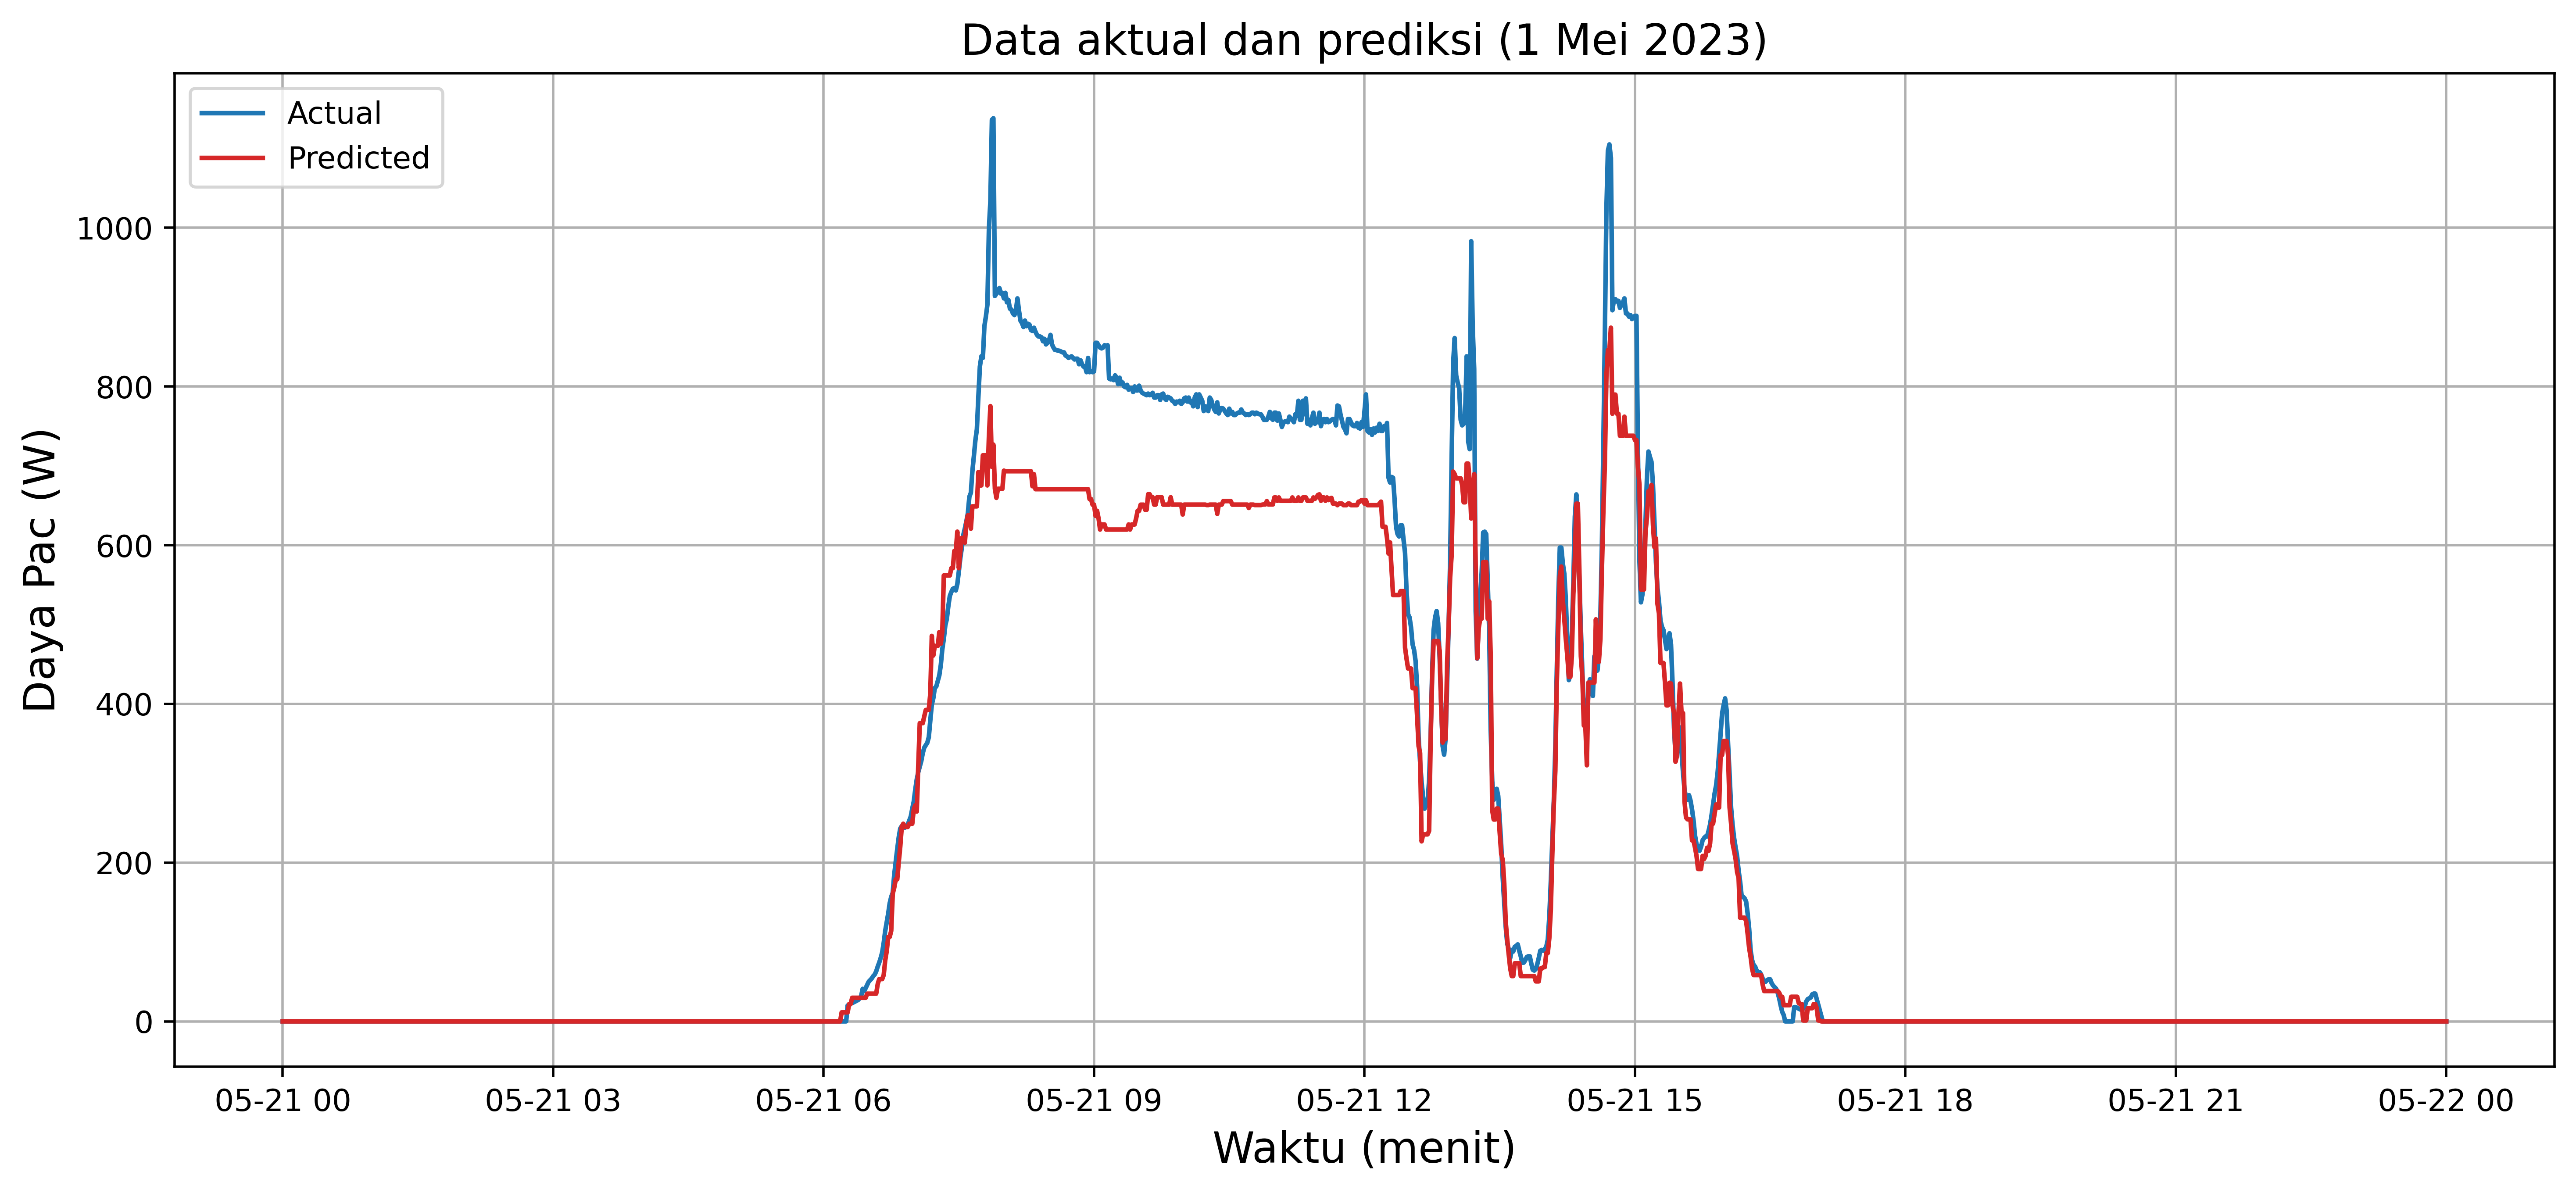

In [74]:
import matplotlib.pyplot as plt
import pandas as pd

# Konversi hasil prediksi menjadi DataFrame
y_pred_reg_df = pd.DataFrame(y_pred_reg, index=y_test_reg.index)

# Filter data hanya untuk rentang tanggal yang ditentukan
start_date = '2023-5-21'
end_date = '2023-5-22'
filtered_actual = y_test_reg[(y_test_reg.index >= start_date) & (y_test_reg.index <= end_date)]
filtered_predicted = y_pred_reg_df[(y_pred_reg_df.index >= start_date) & (y_pred_reg_df.index <= end_date)]

# Plot data aktual dan data yang diprediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

# Plot data aktual
ax.plot(filtered_actual.index, filtered_actual, label="Actual", color='tab:blue')

# Plot data yang diprediksi (misalnya, kolom pertama dari hasil prediksi)
ax.plot(filtered_predicted.index, filtered_predicted.iloc[:, 0], label="Predicted", color='tab:red')

# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (1 Mei 2023)", fontsize=14)
ax.grid()
# Menampilkan legenda
ax.legend(loc='upper left')
# Menyimpan plot ke file gambar
#plt.savefig('Model2a.png')

# Menampilkan plot
plt.show()


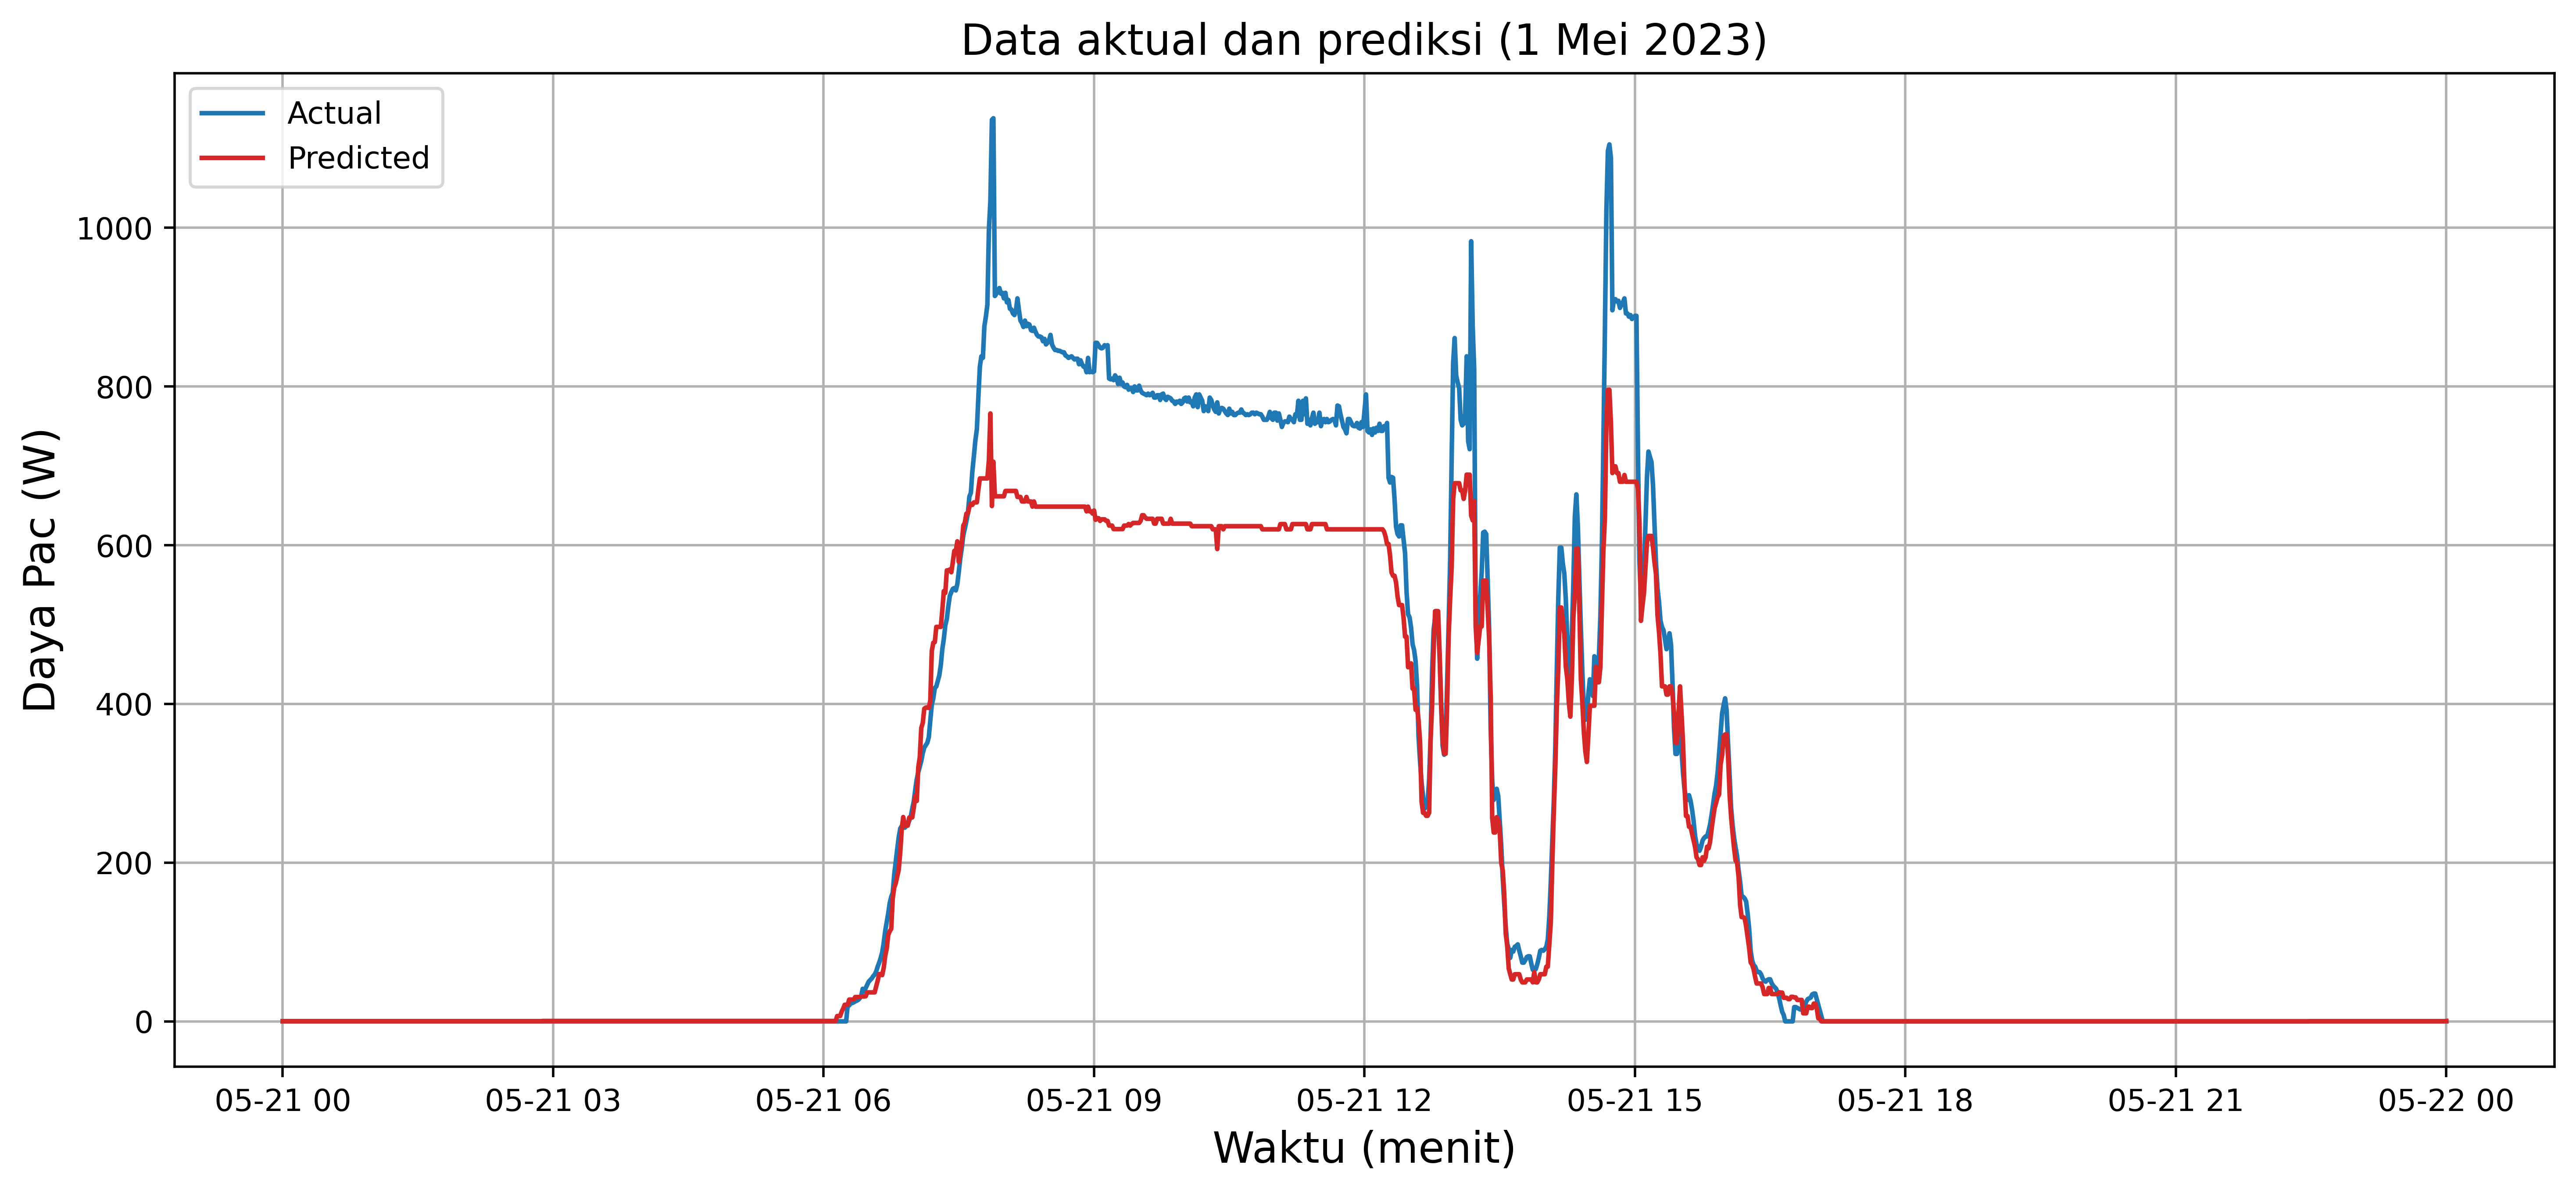

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Konversi hasil prediksi menjadi DataFrame
y_pred_reg_df = pd.DataFrame(y_pred_reg, index=y_test_reg.index)

# Filter data hanya untuk rentang tanggal yang ditentukan
start_date = '2023-5-21'
end_date = '2023-5-22'
filtered_actual = y_test_reg[(y_test_reg.index >= start_date) & (y_test_reg.index <= end_date)]
filtered_predicted = y_pred_reg_df[(y_pred_reg_df.index >= start_date) & (y_pred_reg_df.index <= end_date)]

# Plot data aktual dan data yang diprediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

# Plot data aktual
ax.plot(filtered_actual.index, filtered_actual, label="Actual", color='tab:blue')

# Plot data yang diprediksi (misalnya, kolom pertama dari hasil prediksi)
ax.plot(filtered_predicted.index, filtered_predicted.iloc[:, 0], label="Predicted", color='tab:red')

# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (1 Mei 2023)", fontsize=14)
ax.grid()
# Menampilkan legenda
ax.legend(loc='upper left')
# Menyimpan plot ke file gambar
#plt.savefig('Model2a.png')

# Menampilkan plot
plt.show()


In [51]:

# Fitur numerik untuk regresi
numeric_cols_reg = ['Pac_pvlib', 'solarRad', 'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth','GridMs_Hz', 'Area_PV',
       'number_of_module', 'efic_pv', 'beta', 'Ta', 'day_of_week', 'quarter',
       'month', 'day_of_month', 'day_of_year', 'day', 'hour', 'minute']
# 'GridMs_W_phsA',
# Fitur kategorikal untuk regresi
categoric_cols_reg = ['Op_GriSwStt']

# Fitur numerik untuk klasifikasi
numeric_cols_clf = ['Pac_pvlib', 'solarRad', 'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth', 'GridMs_Hz', 'Area_PV',
       'number_of_module', 'efic_pv', 'beta', 'Ta', 'day_of_week', 'quarter',
       'month', 'day_of_month', 'day_of_year', 'day', 'hour', 'minute']

# Preprocessor untuk regresi
preprocessor_reg = ColumnTransformer([
    ('numeric', 'passthrough', numeric_cols_reg),
    ('categoric', OneHotEncoder(), categoric_cols_reg)
])

# Preprocessor untuk klasifikasi
preprocessor_clf = ColumnTransformer([
    ('numeric', 'passthrough', numeric_cols_clf)
])
# Pipeline untuk regresi
pipeline_reg = Pipeline([
    ('prep', preprocessor_reg),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

# Pipeline untuk klasifikasi
pipeline_clf = Pipeline([
    ('prep', preprocessor_clf),
    ('algo', XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42))
])
# Hyperparameter yang telah ditentukan sebelumnya
params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'reg_lambda': 1.5,
    'gamma': 1.0,
    'min_child_weight': 25,
    'base_score': 0.0,
    'tree_method': 'exact',
}
num_boost_round = 35

# Determine whether to use the data for regression or classification based on 'Op_GriSwStt'
if 'Pac' in train.columns:
    # Regression
    X_train = train.drop(columns=['Pac'])
    y_train = train['Pac']
    X_test = test.drop(columns=['Pac'])
    y_test = test['Pac']
else:
    # Classification
    X_train = train.drop(columns=['Op_GriSwStt'])
    y_train = train['Op_GriSwStt']
    X_test = test.drop(columns=['Op_GriSwStt'])
    y_test = test['Op_GriSwStt']


custom_objective = CustomObjective(Area_PV_train, solarRad_train, efic_pv_train, outsideTemp_train, number_of_module_train, beta_train, Ta_train, lambda_val_train)

# Train the custom XGBoost model for regression
model_custom_reg = XGBoostModel(params, random_seed=42)
model_custom_array = model_custom_reg.fit(X_train_reg, y_train_reg, custom_objective, num_boost_round=num_boost_round, verbose=True)

[0] train loss = 79662.28472762805, gradient (data point ) = 0.575
[1] train loss = 65639.7542457963, gradient (data point ) = 0.5475844668716833
[2] train loss = 54652.15494253396, gradient (data point ) = 0.5327995767368299
[3] train loss = 46028.490602724545, gradient (data point ) = 0.5083721070713199
[4] train loss = 39225.15243682268, gradient (data point ) = 0.5048527094822576
[5] train loss = 33891.56866127315, gradient (data point ) = 0.49852867588255406
[6] train loss = 29687.681318418865, gradient (data point ) = 0.5468836688082462
[7] train loss = 26410.46522332482, gradient (data point ) = 0.5519451949813885
[8] train loss = 23816.407593076514, gradient (data point ) = 0.5708933511031544
[9] train loss = 21769.643308216055, gradient (data point ) = 0.6081708383347088
[10] train loss = 20155.47802257415, gradient (data point ) = 0.5799941311741497
[11] train loss = 18872.918512485634, gradient (data point ) = 0.6030369648586398
[12] train loss = 17867.79644601353, gradient 

In [52]:
# Predict Pac using the trained model
y_pred_reg = model_custom_reg.predict(X_test_reg)

# Evaluate regression model
mse_reg = mean_squared_error(y_test_reg, y_pred_reg)
rmse_reg = np.sqrt(mse_reg)
r2_reg = r2_score(y_test_reg, y_pred_reg)
MAE_reg = mean_absolute_error(y_test_reg, y_pred_reg)
absolute_percentage_error_reg = np.abs((y_test_reg - y_pred_reg) / np.maximum(np.abs(y_test_reg), 1)) * 100
mape_reg = np.mean(np.where(np.isfinite(absolute_percentage_error_reg), absolute_percentage_error_reg, 0))

print('Regression Model Metrics:')
print('Mean Squared Error on Test Set: ', mse_reg)
print('Root Mean Squared Error on Test Set: ', rmse_reg)
print('R2 Score on Test Set: ', r2_reg)
print('Mean Absolute Error on Test Set: ', MAE_reg)
print('Mean Absolute Percentage Error on Test Set: ', mape_reg, '%')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

# Fit model for classification
model_clf = RandomizedSearchCV(pipeline_clf, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_clf.fit(X_train_clf, y_train_clf)

# Predictions for classification
y_pred_clf = model_clf.predict(X_test_clf)

# Print classification results
print("Classification Model Best Params:", model_clf.best_params_)
print("Classification Model Score:", model_clf.score(X_test_clf, y_test_clf))

# Evaluate classification model
accuracy_clf = accuracy_score(y_test_clf, y_pred_clf)
precision_clf = precision_score(y_test_clf, y_pred_clf)
recall_clf = recall_score(y_test_clf, y_pred_clf)
f1_clf = f1_score(y_test_clf, y_pred_clf)

print('Classification Model Metrics:')
print('Accuracy: ', accuracy_clf)
print('Precision: ', precision_clf)
print('Recall: ', recall_clf)
print('F1 Score: ', f1_clf)

# Compare Actual and Predicted Values for Classification
pd.DataFrame({"Actual": y_test_clf, "Predicted": y_pred_clf})[::1000]

Regression Model Metrics:
Mean Squared Error on Test Set:  21685.7498966024
Root Mean Squared Error on Test Set:  147.2608226807198
R2 Score on Test Set:  0.8618464525048616
Mean Absolute Error on Test Set:  75.23343701565567
Mean Absolute Percentage Error on Test Set:  107.84594286514702 %
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Classification Model Best Params: {'algo__colsample_bytree': 0.7950202923669918, 'algo__gamma': 8, 'algo__learning_rate': 0.010257563974185648, 'algo__max_depth': 3, 'algo__n_estimators': 180, 'algo__reg_alpha': 0.7004349545230065, 'algo__reg_lambda': 1.4477786306928684, 'algo__subsample': 0.6029799873905057}
Classification Model Score: 0.9541922719113196
Classification Model Metrics:
Accuracy:  0.9541922719113196
Precision:  0.9004180512380748
Recall:  0.9726349917017253
F1 Score:  0.9351343327890752


Actual  Predicted
minute_timestamp                      
2023-05-01 00:00:00       0          0
2023-05-01 16:40:00       1          1
2023-06-01 09:20:00       1          1
2023-05-02 02:00:00       0          0
2023-05-02 18:40:00       0          0
...                     ...        ...
2023-06-07 00:01:00       0          0
2023-06-07 16:41:00       0          0
2023-05-08 09:21:00       1          1
2023-06-08 02:01:00       0          0
2023-06-08 18:41:00       1          0

[77 rows x 2 columns]

In [36]:
# Filter hasil prediksi regresi yang negatif
negative_predictions_reg = y_pred_reg[y_pred_reg < 0]

# Print hasil prediksi regresi yang negatif
print("Hasil Prediksi Regresi yang Negatif:", negative_predictions_reg)
# Hitung jumlah baris hasil prediksi regresi yang negatif
jumlah_baris_negatif_reg = negative_predictions_reg.shape[0]

# Print jumlah baris hasil prediksi regresi yang negatif
print("Jumlah Baris dengan Hasil Prediksi Regresi yang Negatif:", jumlah_baris_negatif_reg)


Hasil Prediksi Regresi yang Negatif: []
Jumlah Baris dengan Hasil Prediksi Regresi yang Negatif: 0


In [42]:
from datetime import time

# Filter data untuk rentang waktu dari jam 18.02 sampai 05.30
filtered_df = predictions_df[
    ((predictions_df['Timestamp'].dt.hour == 18) & (predictions_df['Timestamp'].dt.minute >= 4)) |  # Jam 18:02 atau lebih
    (predictions_df['Timestamp'].dt.hour > 18) |  # Jam setelah 18:00
    ((predictions_df['Timestamp'].dt.hour == 5) & (predictions_df['Timestamp'].dt.minute <= 30))  # Jam 05:30 atau kurang
]

# Filter data dengan Predicted_Pac tidak nol
nonzero_predictions = filtered_df[filtered_df['Predicted_Pac'] != 0]

# Print informasi untuk Predicted_Pac tidak nol
print("Jumlah baris dengan Predicted_Pac tidak nol pada rentang waktu 18.02-05.30:", nonzero_predictions.shape[0])
print("Detail prediksi tidak nol:")
for index, row in nonzero_predictions.iterrows():
    print(f"Baris ke-{index}, Tanggal: {row['Timestamp'].date()}, Jam: {row['Timestamp'].time()}, Predicted_Pac: {row['Predicted_Pac']}")


Jumlah baris dengan Predicted_Pac tidak nol pada rentang waktu 18.02-05.30: 20510
Detail prediksi tidak nol:
Baris ke-2023-05-01 05:00:00, Tanggal: 2023-05-01, Jam: 05:00:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-01 05:01:00, Tanggal: 2023-05-01, Jam: 05:01:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-01 05:02:00, Tanggal: 2023-05-01, Jam: 05:02:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-01 05:03:00, Tanggal: 2023-05-01, Jam: 05:03:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-01 05:04:00, Tanggal: 2023-05-01, Jam: 05:04:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-01 05:05:00, Tanggal: 2023-05-01, Jam: 05:05:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-01 05:06:00, Tanggal: 2023-05-01, Jam: 05:06:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-01 05:07:00, Tanggal: 2023-05-01, Jam: 05:07:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-01 05:08:00, Tanggal: 2023-05-01, Jam: 05:08:00, Predicted_Pac: 0.428450198638862


Baris ke-2023-05-02 19:46:00, Tanggal: 2023-05-02, Jam: 19:46:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-02 19:47:00, Tanggal: 2023-05-02, Jam: 19:47:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-02 19:48:00, Tanggal: 2023-05-02, Jam: 19:48:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-02 19:49:00, Tanggal: 2023-05-02, Jam: 19:49:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-02 19:50:00, Tanggal: 2023-05-02, Jam: 19:50:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-02 19:51:00, Tanggal: 2023-05-02, Jam: 19:51:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-02 19:52:00, Tanggal: 2023-05-02, Jam: 19:52:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-02 19:53:00, Tanggal: 2023-05-02, Jam: 19:53:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-02 19:54:00, Tanggal: 2023-05-02, Jam: 19:54:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-02 19:55:00, Tanggal: 2023-05-02, Jam: 19:55:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-05-03 05:00:00, Tanggal: 2023-05-03, Jam: 05:00:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-03 05:01:00, Tanggal: 2023-05-03, Jam: 05:01:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-03 05:02:00, Tanggal: 2023-05-03, Jam: 05:02:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-03 05:03:00, Tanggal: 2023-05-03, Jam: 05:03:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-03 05:04:00, Tanggal: 2023-05-03, Jam: 05:04:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-03 05:05:00, Tanggal: 2023-05-03, Jam: 05:05:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-03 05:06:00, Tanggal: 2023-05-03, Jam: 05:06:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-03 05:07:00, Tanggal: 2023-05-03, Jam: 05:07:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-03 05:08:00, Tanggal: 2023-05-03, Jam: 05:08:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-03 05:09:00, Tanggal: 2023-05-03, Jam: 05:09:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-05-04 19:01:00, Tanggal: 2023-05-04, Jam: 19:01:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-04 19:02:00, Tanggal: 2023-05-04, Jam: 19:02:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-04 19:03:00, Tanggal: 2023-05-04, Jam: 19:03:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-04 19:04:00, Tanggal: 2023-05-04, Jam: 19:04:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-04 19:05:00, Tanggal: 2023-05-04, Jam: 19:05:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-04 19:06:00, Tanggal: 2023-05-04, Jam: 19:06:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-04 19:07:00, Tanggal: 2023-05-04, Jam: 19:07:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-04 19:08:00, Tanggal: 2023-05-04, Jam: 19:08:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-04 19:09:00, Tanggal: 2023-05-04, Jam: 19:09:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-04 19:10:00, Tanggal: 2023-05-04, Jam: 19:10:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-04 23:11:00, Tanggal: 2023-06-04, Jam: 23:11:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-04 23:12:00, Tanggal: 2023-06-04, Jam: 23:12:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-04 23:13:00, Tanggal: 2023-06-04, Jam: 23:13:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-04 23:14:00, Tanggal: 2023-06-04, Jam: 23:14:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-04 23:15:00, Tanggal: 2023-06-04, Jam: 23:15:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-04 23:16:00, Tanggal: 2023-06-04, Jam: 23:16:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-04 23:17:00, Tanggal: 2023-06-04, Jam: 23:17:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-04 23:18:00, Tanggal: 2023-06-04, Jam: 23:18:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-04 23:19:00, Tanggal: 2023-06-04, Jam: 23:19:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-04 23:20:00, Tanggal: 2023-06-04, Jam: 23:20:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-05 23:45:00, Tanggal: 2023-06-05, Jam: 23:45:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-05 23:46:00, Tanggal: 2023-06-05, Jam: 23:46:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-05 23:47:00, Tanggal: 2023-06-05, Jam: 23:47:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-05 23:48:00, Tanggal: 2023-06-05, Jam: 23:48:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-05 23:49:00, Tanggal: 2023-06-05, Jam: 23:49:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-05 23:50:00, Tanggal: 2023-06-05, Jam: 23:50:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-05 23:51:00, Tanggal: 2023-06-05, Jam: 23:51:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-05 23:52:00, Tanggal: 2023-06-05, Jam: 23:52:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-05 23:53:00, Tanggal: 2023-06-05, Jam: 23:53:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-05 23:54:00, Tanggal: 2023-06-05, Jam: 23:54:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-05-14 22:22:00, Tanggal: 2023-05-14, Jam: 22:22:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-14 22:23:00, Tanggal: 2023-05-14, Jam: 22:23:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-14 22:24:00, Tanggal: 2023-05-14, Jam: 22:24:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-14 22:25:00, Tanggal: 2023-05-14, Jam: 22:25:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-14 22:26:00, Tanggal: 2023-05-14, Jam: 22:26:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-14 22:27:00, Tanggal: 2023-05-14, Jam: 22:27:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-14 22:28:00, Tanggal: 2023-05-14, Jam: 22:28:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-14 22:29:00, Tanggal: 2023-05-14, Jam: 22:29:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-14 22:30:00, Tanggal: 2023-05-14, Jam: 22:30:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-14 22:31:00, Tanggal: 2023-05-14, Jam: 22:31:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-05-16 22:48:00, Tanggal: 2023-05-16, Jam: 22:48:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-16 22:49:00, Tanggal: 2023-05-16, Jam: 22:49:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-16 22:50:00, Tanggal: 2023-05-16, Jam: 22:50:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-16 22:51:00, Tanggal: 2023-05-16, Jam: 22:51:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-16 22:52:00, Tanggal: 2023-05-16, Jam: 22:52:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-16 22:53:00, Tanggal: 2023-05-16, Jam: 22:53:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-16 22:54:00, Tanggal: 2023-05-16, Jam: 22:54:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-16 22:55:00, Tanggal: 2023-05-16, Jam: 22:55:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-16 22:56:00, Tanggal: 2023-05-16, Jam: 22:56:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-16 22:57:00, Tanggal: 2023-05-16, Jam: 22:57:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-05-18 21:33:00, Tanggal: 2023-05-18, Jam: 21:33:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-18 21:34:00, Tanggal: 2023-05-18, Jam: 21:34:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-18 21:35:00, Tanggal: 2023-05-18, Jam: 21:35:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-18 21:36:00, Tanggal: 2023-05-18, Jam: 21:36:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-18 21:37:00, Tanggal: 2023-05-18, Jam: 21:37:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-18 21:38:00, Tanggal: 2023-05-18, Jam: 21:38:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-18 21:39:00, Tanggal: 2023-05-18, Jam: 21:39:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-18 21:40:00, Tanggal: 2023-05-18, Jam: 21:40:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-18 21:41:00, Tanggal: 2023-05-18, Jam: 21:41:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-18 21:42:00, Tanggal: 2023-05-18, Jam: 21:42:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-05-20 20:27:00, Tanggal: 2023-05-20, Jam: 20:27:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-20 20:28:00, Tanggal: 2023-05-20, Jam: 20:28:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-20 20:29:00, Tanggal: 2023-05-20, Jam: 20:29:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-20 20:30:00, Tanggal: 2023-05-20, Jam: 20:30:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-20 20:31:00, Tanggal: 2023-05-20, Jam: 20:31:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-20 20:32:00, Tanggal: 2023-05-20, Jam: 20:32:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-20 20:33:00, Tanggal: 2023-05-20, Jam: 20:33:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-20 20:34:00, Tanggal: 2023-05-20, Jam: 20:34:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-20 20:35:00, Tanggal: 2023-05-20, Jam: 20:35:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-20 20:36:00, Tanggal: 2023-05-20, Jam: 20:36:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-05-22 19:35:00, Tanggal: 2023-05-22, Jam: 19:35:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-22 19:36:00, Tanggal: 2023-05-22, Jam: 19:36:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-22 19:37:00, Tanggal: 2023-05-22, Jam: 19:37:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-22 19:38:00, Tanggal: 2023-05-22, Jam: 19:38:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-22 19:39:00, Tanggal: 2023-05-22, Jam: 19:39:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-22 19:40:00, Tanggal: 2023-05-22, Jam: 19:40:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-22 19:41:00, Tanggal: 2023-05-22, Jam: 19:41:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-22 19:42:00, Tanggal: 2023-05-22, Jam: 19:42:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-22 19:43:00, Tanggal: 2023-05-22, Jam: 19:43:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-22 19:44:00, Tanggal: 2023-05-22, Jam: 19:44:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-05-23 21:13:00, Tanggal: 2023-05-23, Jam: 21:13:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-23 21:14:00, Tanggal: 2023-05-23, Jam: 21:14:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-23 21:15:00, Tanggal: 2023-05-23, Jam: 21:15:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-23 21:16:00, Tanggal: 2023-05-23, Jam: 21:16:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-23 21:17:00, Tanggal: 2023-05-23, Jam: 21:17:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-23 21:18:00, Tanggal: 2023-05-23, Jam: 21:18:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-23 21:19:00, Tanggal: 2023-05-23, Jam: 21:19:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-23 21:20:00, Tanggal: 2023-05-23, Jam: 21:20:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-23 21:21:00, Tanggal: 2023-05-23, Jam: 21:21:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-23 21:22:00, Tanggal: 2023-05-23, Jam: 21:22:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-05-25 21:03:00, Tanggal: 2023-05-25, Jam: 21:03:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-25 21:04:00, Tanggal: 2023-05-25, Jam: 21:04:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-25 21:05:00, Tanggal: 2023-05-25, Jam: 21:05:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-25 21:06:00, Tanggal: 2023-05-25, Jam: 21:06:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-25 21:07:00, Tanggal: 2023-05-25, Jam: 21:07:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-25 21:08:00, Tanggal: 2023-05-25, Jam: 21:08:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-25 21:09:00, Tanggal: 2023-05-25, Jam: 21:09:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-25 21:10:00, Tanggal: 2023-05-25, Jam: 21:10:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-25 21:11:00, Tanggal: 2023-05-25, Jam: 21:11:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-25 21:12:00, Tanggal: 2023-05-25, Jam: 21:12:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-05-27 05:21:00, Tanggal: 2023-05-27, Jam: 05:21:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-27 05:22:00, Tanggal: 2023-05-27, Jam: 05:22:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-27 05:23:00, Tanggal: 2023-05-27, Jam: 05:23:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-27 05:24:00, Tanggal: 2023-05-27, Jam: 05:24:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-27 05:25:00, Tanggal: 2023-05-27, Jam: 05:25:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-27 05:26:00, Tanggal: 2023-05-27, Jam: 05:26:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-27 05:27:00, Tanggal: 2023-05-27, Jam: 05:27:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-27 05:28:00, Tanggal: 2023-05-27, Jam: 05:28:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-27 05:29:00, Tanggal: 2023-05-27, Jam: 05:29:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-27 05:30:00, Tanggal: 2023-05-27, Jam: 05:30:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-05-28 21:31:00, Tanggal: 2023-05-28, Jam: 21:31:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-28 21:32:00, Tanggal: 2023-05-28, Jam: 21:32:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-28 21:33:00, Tanggal: 2023-05-28, Jam: 21:33:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-28 21:34:00, Tanggal: 2023-05-28, Jam: 21:34:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-28 21:35:00, Tanggal: 2023-05-28, Jam: 21:35:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-28 21:36:00, Tanggal: 2023-05-28, Jam: 21:36:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-28 21:37:00, Tanggal: 2023-05-28, Jam: 21:37:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-28 21:38:00, Tanggal: 2023-05-28, Jam: 21:38:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-28 21:39:00, Tanggal: 2023-05-28, Jam: 21:39:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-28 21:40:00, Tanggal: 2023-05-28, Jam: 21:40:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-05-30 18:51:00, Tanggal: 2023-05-30, Jam: 18:51:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-30 18:52:00, Tanggal: 2023-05-30, Jam: 18:52:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-30 18:53:00, Tanggal: 2023-05-30, Jam: 18:53:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-30 18:54:00, Tanggal: 2023-05-30, Jam: 18:54:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-30 18:55:00, Tanggal: 2023-05-30, Jam: 18:55:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-30 18:56:00, Tanggal: 2023-05-30, Jam: 18:56:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-30 18:57:00, Tanggal: 2023-05-30, Jam: 18:57:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-30 18:58:00, Tanggal: 2023-05-30, Jam: 18:58:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-30 18:59:00, Tanggal: 2023-05-30, Jam: 18:59:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-30 19:00:00, Tanggal: 2023-05-30, Jam: 19:00:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-05-06 20:37:00, Tanggal: 2023-05-06, Jam: 20:37:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-06 20:38:00, Tanggal: 2023-05-06, Jam: 20:38:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-06 20:39:00, Tanggal: 2023-05-06, Jam: 20:39:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-06 20:40:00, Tanggal: 2023-05-06, Jam: 20:40:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-06 20:41:00, Tanggal: 2023-05-06, Jam: 20:41:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-06 20:42:00, Tanggal: 2023-05-06, Jam: 20:42:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-06 20:43:00, Tanggal: 2023-05-06, Jam: 20:43:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-06 20:44:00, Tanggal: 2023-05-06, Jam: 20:44:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-06 20:45:00, Tanggal: 2023-05-06, Jam: 20:45:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-06 20:46:00, Tanggal: 2023-05-06, Jam: 20:46:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-13 18:16:00, Tanggal: 2023-06-13, Jam: 18:16:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-13 18:17:00, Tanggal: 2023-06-13, Jam: 18:17:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-13 18:18:00, Tanggal: 2023-06-13, Jam: 18:18:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-13 18:19:00, Tanggal: 2023-06-13, Jam: 18:19:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-13 18:20:00, Tanggal: 2023-06-13, Jam: 18:20:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-13 18:21:00, Tanggal: 2023-06-13, Jam: 18:21:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-13 18:22:00, Tanggal: 2023-06-13, Jam: 18:22:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-13 18:23:00, Tanggal: 2023-06-13, Jam: 18:23:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-13 18:24:00, Tanggal: 2023-06-13, Jam: 18:24:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-13 18:25:00, Tanggal: 2023-06-13, Jam: 18:25:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-14 23:35:00, Tanggal: 2023-06-14, Jam: 23:35:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-14 23:36:00, Tanggal: 2023-06-14, Jam: 23:36:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-14 23:37:00, Tanggal: 2023-06-14, Jam: 23:37:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-14 23:38:00, Tanggal: 2023-06-14, Jam: 23:38:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-14 23:39:00, Tanggal: 2023-06-14, Jam: 23:39:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-14 23:40:00, Tanggal: 2023-06-14, Jam: 23:40:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-14 23:41:00, Tanggal: 2023-06-14, Jam: 23:41:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-14 23:42:00, Tanggal: 2023-06-14, Jam: 23:42:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-14 23:43:00, Tanggal: 2023-06-14, Jam: 23:43:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-14 23:44:00, Tanggal: 2023-06-14, Jam: 23:44:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-16 23:51:00, Tanggal: 2023-06-16, Jam: 23:51:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-16 23:52:00, Tanggal: 2023-06-16, Jam: 23:52:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-16 23:53:00, Tanggal: 2023-06-16, Jam: 23:53:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-16 23:54:00, Tanggal: 2023-06-16, Jam: 23:54:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-16 23:55:00, Tanggal: 2023-06-16, Jam: 23:55:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-16 23:56:00, Tanggal: 2023-06-16, Jam: 23:56:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-16 23:57:00, Tanggal: 2023-06-16, Jam: 23:57:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-16 23:58:00, Tanggal: 2023-06-16, Jam: 23:58:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-16 23:59:00, Tanggal: 2023-06-16, Jam: 23:59:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-17 05:00:00, Tanggal: 2023-06-17, Jam: 05:00:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-18 20:52:00, Tanggal: 2023-06-18, Jam: 20:52:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-18 20:53:00, Tanggal: 2023-06-18, Jam: 20:53:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-18 20:54:00, Tanggal: 2023-06-18, Jam: 20:54:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-18 20:55:00, Tanggal: 2023-06-18, Jam: 20:55:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-18 20:56:00, Tanggal: 2023-06-18, Jam: 20:56:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-18 20:57:00, Tanggal: 2023-06-18, Jam: 20:57:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-18 20:58:00, Tanggal: 2023-06-18, Jam: 20:58:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-18 20:59:00, Tanggal: 2023-06-18, Jam: 20:59:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-18 21:00:00, Tanggal: 2023-06-18, Jam: 21:00:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-18 21:01:00, Tanggal: 2023-06-18, Jam: 21:01:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-20 18:54:00, Tanggal: 2023-06-20, Jam: 18:54:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-20 18:55:00, Tanggal: 2023-06-20, Jam: 18:55:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-20 18:56:00, Tanggal: 2023-06-20, Jam: 18:56:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-20 18:57:00, Tanggal: 2023-06-20, Jam: 18:57:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-20 18:58:00, Tanggal: 2023-06-20, Jam: 18:58:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-20 18:59:00, Tanggal: 2023-06-20, Jam: 18:59:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-20 19:00:00, Tanggal: 2023-06-20, Jam: 19:00:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-20 19:01:00, Tanggal: 2023-06-20, Jam: 19:01:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-20 19:02:00, Tanggal: 2023-06-20, Jam: 19:02:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-20 19:03:00, Tanggal: 2023-06-20, Jam: 19:03:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-21 19:35:00, Tanggal: 2023-06-21, Jam: 19:35:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-21 19:36:00, Tanggal: 2023-06-21, Jam: 19:36:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-21 19:37:00, Tanggal: 2023-06-21, Jam: 19:37:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-21 19:38:00, Tanggal: 2023-06-21, Jam: 19:38:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-21 19:39:00, Tanggal: 2023-06-21, Jam: 19:39:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-21 19:40:00, Tanggal: 2023-06-21, Jam: 19:40:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-21 19:41:00, Tanggal: 2023-06-21, Jam: 19:41:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-21 19:42:00, Tanggal: 2023-06-21, Jam: 19:42:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-21 19:43:00, Tanggal: 2023-06-21, Jam: 19:43:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-21 19:44:00, Tanggal: 2023-06-21, Jam: 19:44:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-23 19:36:00, Tanggal: 2023-06-23, Jam: 19:36:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-23 19:37:00, Tanggal: 2023-06-23, Jam: 19:37:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-23 19:38:00, Tanggal: 2023-06-23, Jam: 19:38:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-23 19:39:00, Tanggal: 2023-06-23, Jam: 19:39:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-23 19:40:00, Tanggal: 2023-06-23, Jam: 19:40:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-23 19:41:00, Tanggal: 2023-06-23, Jam: 19:41:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-23 19:42:00, Tanggal: 2023-06-23, Jam: 19:42:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-23 19:43:00, Tanggal: 2023-06-23, Jam: 19:43:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-23 19:44:00, Tanggal: 2023-06-23, Jam: 19:44:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-23 19:45:00, Tanggal: 2023-06-23, Jam: 19:45:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-24 23:20:00, Tanggal: 2023-06-24, Jam: 23:20:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-24 23:21:00, Tanggal: 2023-06-24, Jam: 23:21:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-24 23:22:00, Tanggal: 2023-06-24, Jam: 23:22:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-24 23:23:00, Tanggal: 2023-06-24, Jam: 23:23:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-24 23:24:00, Tanggal: 2023-06-24, Jam: 23:24:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-24 23:25:00, Tanggal: 2023-06-24, Jam: 23:25:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-24 23:26:00, Tanggal: 2023-06-24, Jam: 23:26:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-24 23:27:00, Tanggal: 2023-06-24, Jam: 23:27:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-24 23:28:00, Tanggal: 2023-06-24, Jam: 23:28:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-24 23:29:00, Tanggal: 2023-06-24, Jam: 23:29:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-26 22:04:00, Tanggal: 2023-06-26, Jam: 22:04:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-26 22:05:00, Tanggal: 2023-06-26, Jam: 22:05:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-26 22:06:00, Tanggal: 2023-06-26, Jam: 22:06:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-26 22:07:00, Tanggal: 2023-06-26, Jam: 22:07:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-26 22:08:00, Tanggal: 2023-06-26, Jam: 22:08:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-26 22:09:00, Tanggal: 2023-06-26, Jam: 22:09:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-26 22:10:00, Tanggal: 2023-06-26, Jam: 22:10:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-26 22:11:00, Tanggal: 2023-06-26, Jam: 22:11:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-26 22:12:00, Tanggal: 2023-06-26, Jam: 22:12:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-26 22:13:00, Tanggal: 2023-06-26, Jam: 22:13:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-28 21:11:00, Tanggal: 2023-06-28, Jam: 21:11:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-28 21:12:00, Tanggal: 2023-06-28, Jam: 21:12:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-28 21:13:00, Tanggal: 2023-06-28, Jam: 21:13:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-28 21:14:00, Tanggal: 2023-06-28, Jam: 21:14:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-28 21:15:00, Tanggal: 2023-06-28, Jam: 21:15:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-28 21:16:00, Tanggal: 2023-06-28, Jam: 21:16:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-28 21:17:00, Tanggal: 2023-06-28, Jam: 21:17:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-28 21:18:00, Tanggal: 2023-06-28, Jam: 21:18:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-28 21:19:00, Tanggal: 2023-06-28, Jam: 21:19:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-28 21:20:00, Tanggal: 2023-06-28, Jam: 21:20:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-30 19:26:00, Tanggal: 2023-06-30, Jam: 19:26:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-30 19:27:00, Tanggal: 2023-06-30, Jam: 19:27:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-30 19:28:00, Tanggal: 2023-06-30, Jam: 19:28:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-30 19:29:00, Tanggal: 2023-06-30, Jam: 19:29:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-30 19:30:00, Tanggal: 2023-06-30, Jam: 19:30:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-30 19:31:00, Tanggal: 2023-06-30, Jam: 19:31:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-30 19:32:00, Tanggal: 2023-06-30, Jam: 19:32:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-30 19:33:00, Tanggal: 2023-06-30, Jam: 19:33:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-30 19:34:00, Tanggal: 2023-06-30, Jam: 19:34:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-30 19:35:00, Tanggal: 2023-06-30, Jam: 19:35:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-07 18:16:00, Tanggal: 2023-06-07, Jam: 18:16:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-07 18:17:00, Tanggal: 2023-06-07, Jam: 18:17:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-07 18:18:00, Tanggal: 2023-06-07, Jam: 18:18:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-07 18:19:00, Tanggal: 2023-06-07, Jam: 18:19:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-07 18:20:00, Tanggal: 2023-06-07, Jam: 18:20:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-07 18:21:00, Tanggal: 2023-06-07, Jam: 18:21:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-07 18:22:00, Tanggal: 2023-06-07, Jam: 18:22:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-07 18:23:00, Tanggal: 2023-06-07, Jam: 18:23:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-07 18:24:00, Tanggal: 2023-06-07, Jam: 18:24:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-07 18:25:00, Tanggal: 2023-06-07, Jam: 18:25:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-05-08 19:24:00, Tanggal: 2023-05-08, Jam: 19:24:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-08 19:25:00, Tanggal: 2023-05-08, Jam: 19:25:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-08 19:26:00, Tanggal: 2023-05-08, Jam: 19:26:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-08 19:27:00, Tanggal: 2023-05-08, Jam: 19:27:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-08 19:28:00, Tanggal: 2023-05-08, Jam: 19:28:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-08 19:29:00, Tanggal: 2023-05-08, Jam: 19:29:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-08 19:30:00, Tanggal: 2023-05-08, Jam: 19:30:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-08 19:31:00, Tanggal: 2023-05-08, Jam: 19:31:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-08 19:32:00, Tanggal: 2023-05-08, Jam: 19:32:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-05-08 19:33:00, Tanggal: 2023-05-08, Jam: 19:33:00, Predicted_Pac: 0.428450198638862
Baris ke-2

Baris ke-2023-06-08 23:20:00, Tanggal: 2023-06-08, Jam: 23:20:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-08 23:21:00, Tanggal: 2023-06-08, Jam: 23:21:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-08 23:22:00, Tanggal: 2023-06-08, Jam: 23:22:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-08 23:23:00, Tanggal: 2023-06-08, Jam: 23:23:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-08 23:24:00, Tanggal: 2023-06-08, Jam: 23:24:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-08 23:25:00, Tanggal: 2023-06-08, Jam: 23:25:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-08 23:26:00, Tanggal: 2023-06-08, Jam: 23:26:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-08 23:27:00, Tanggal: 2023-06-08, Jam: 23:27:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-08 23:28:00, Tanggal: 2023-06-08, Jam: 23:28:00, Predicted_Pac: 0.428450198638862
Baris ke-2023-06-08 23:29:00, Tanggal: 2023-06-08, Jam: 23:29:00, Predicted_Pac: 0.428450198638862
Baris ke-2

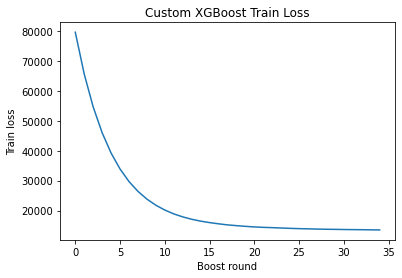

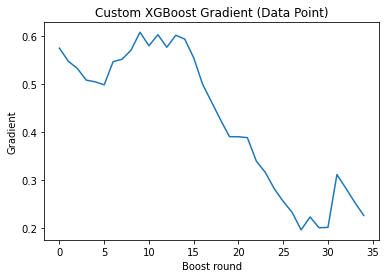

In [54]:
# Plot the custom XGBoost training loss
plt.plot(model_custom_array[0])
plt.xlabel('Boost round')
plt.ylabel('Train loss')
plt.title('Custom XGBoost Train Loss')
plt.show()

# Plot the custom XGBoost gradient (for data point 1)
plt.plot(model_custom_array[1])
plt.xlabel('Boost round')
plt.ylabel('Gradient')
plt.title('Custom XGBoost Gradient (Data Point)')
plt.show()


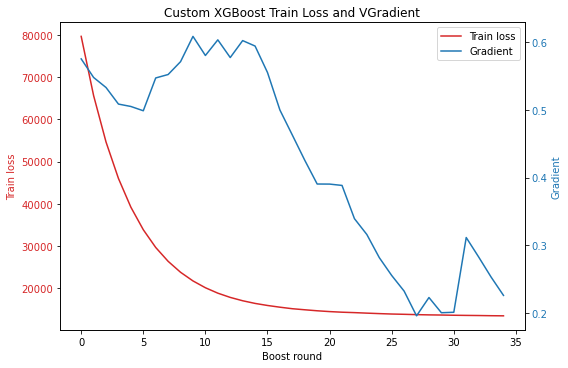

In [55]:
import matplotlib.pyplot as plt

# Plot the custom XGBoost training loss and Gradient
fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:red'
ax1.set_xlabel('Boost round')
ax1.set_ylabel('Train loss', color=color)
ax1.plot(model_custom_array[0], label='Train loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Gradient', color=color)
ax2.plot(model_custom_array[1], label='Gradient', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add labels for each line and adjust legend position
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

fig.tight_layout()  
plt.title('Custom XGBoost Train Loss and VGradient')
plt.show()


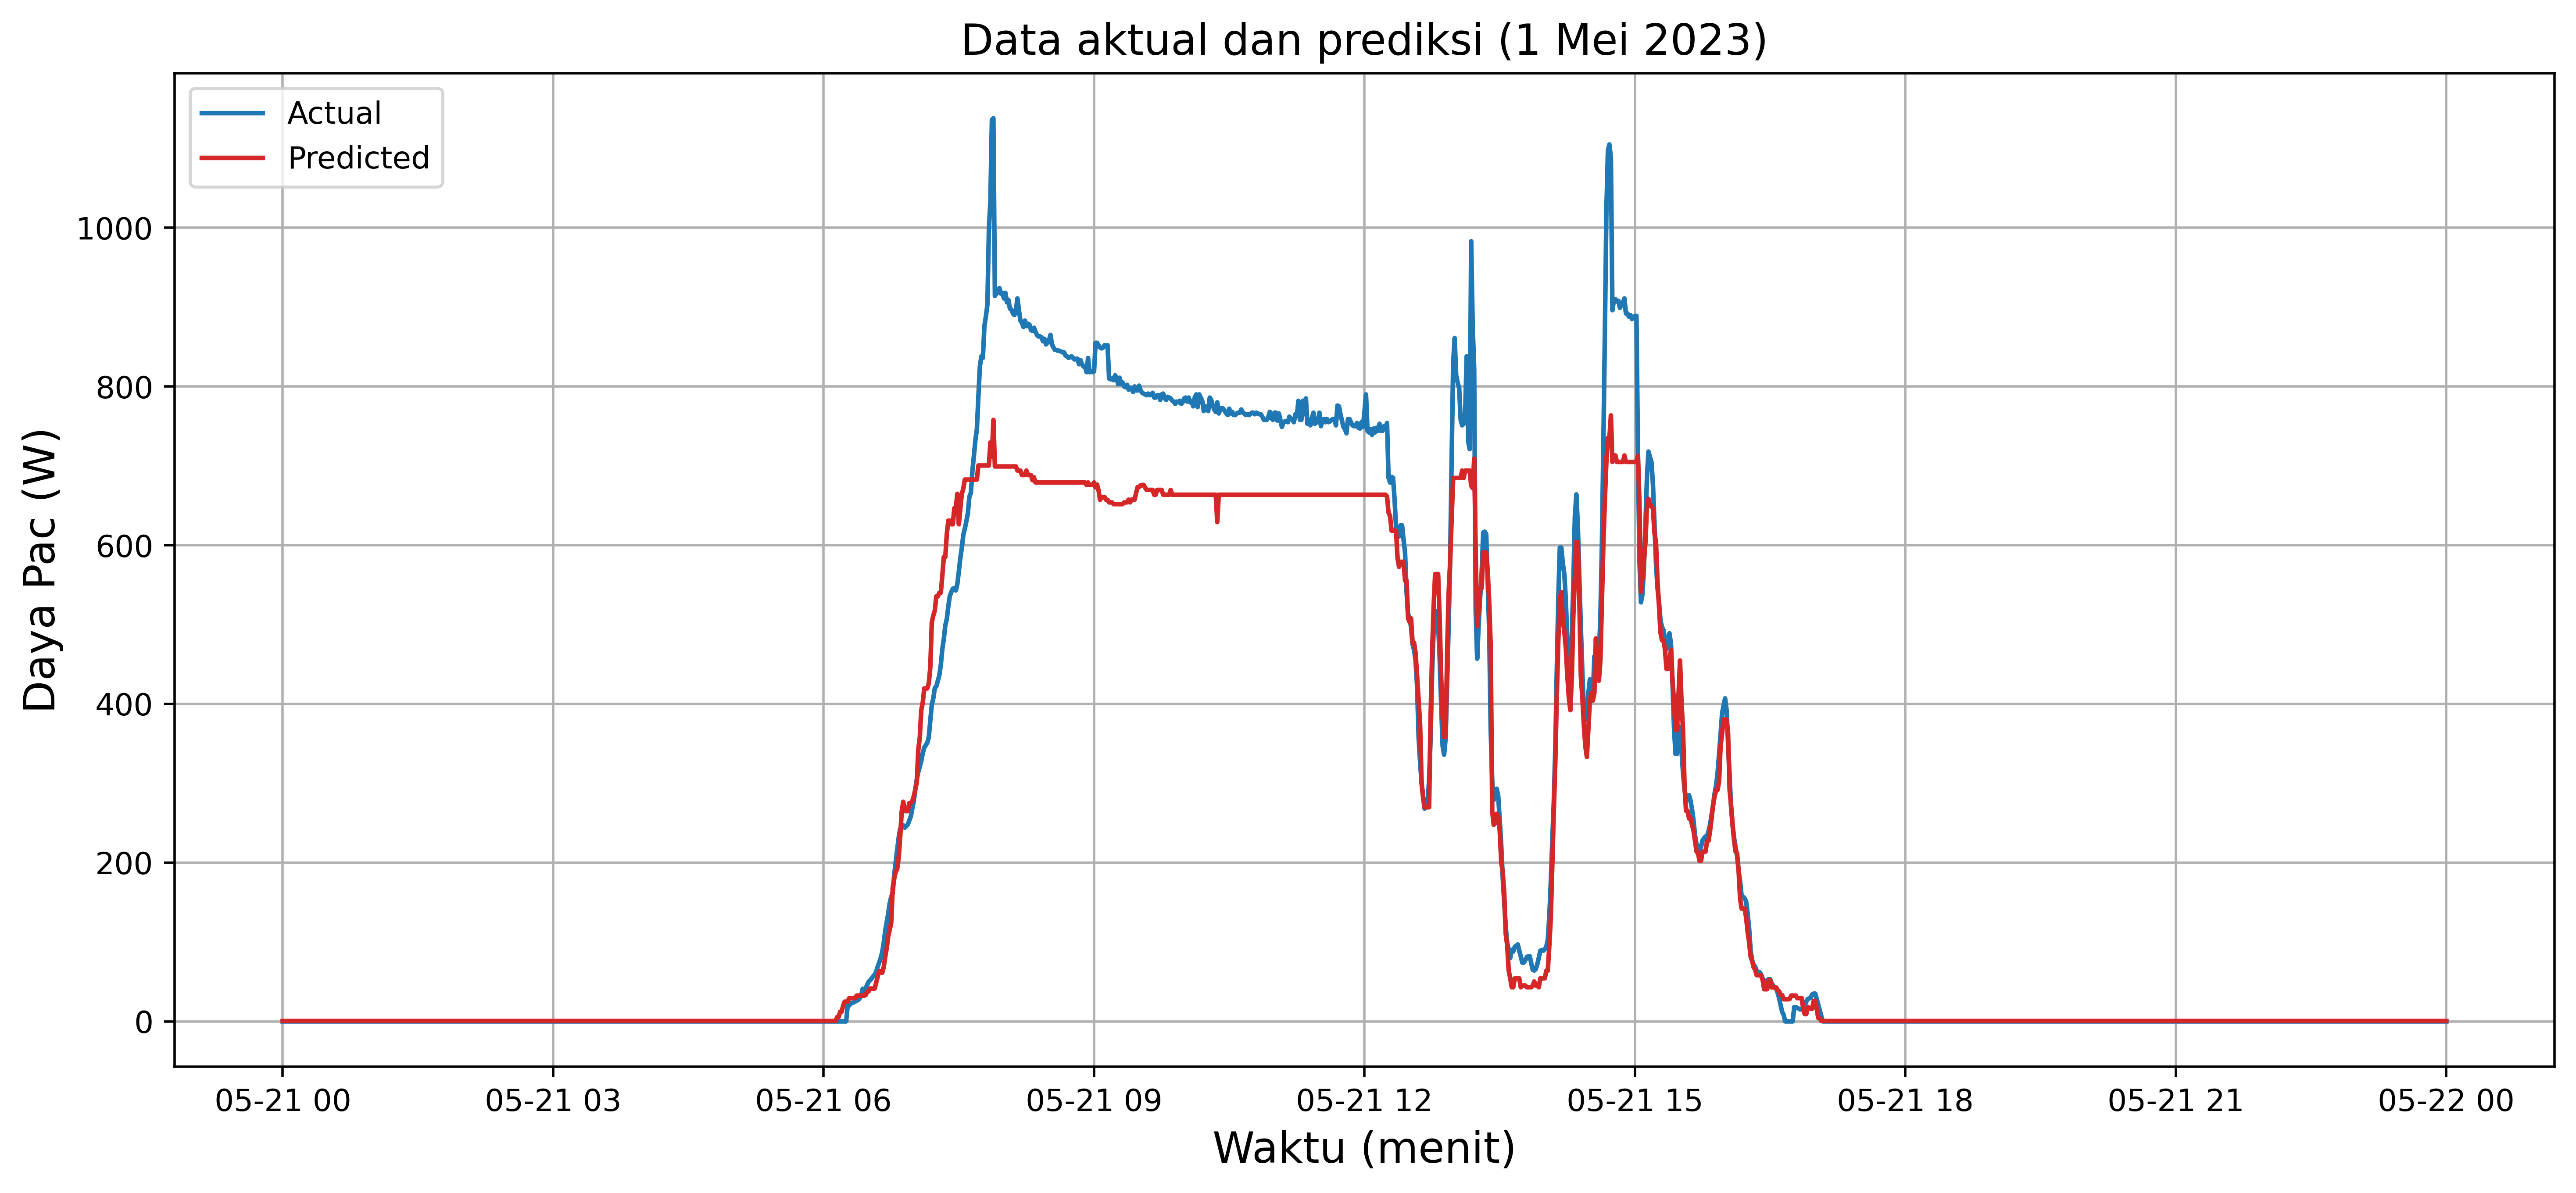

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Konversi hasil prediksi menjadi DataFrame
y_pred_reg_df = pd.DataFrame(y_pred_reg, index=y_test_reg.index)

# Filter data hanya untuk rentang tanggal yang ditentukan
start_date = '2023-5-21'
end_date = '2023-5-22'
filtered_actual = y_test_reg[(y_test_reg.index >= start_date) & (y_test_reg.index <= end_date)]
filtered_predicted = y_pred_reg_df[(y_pred_reg_df.index >= start_date) & (y_pred_reg_df.index <= end_date)]

# Plot data aktual dan data yang diprediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

# Plot data aktual
ax.plot(filtered_actual.index, filtered_actual, label="Actual", color='tab:blue')

# Plot data yang diprediksi (misalnya, kolom pertama dari hasil prediksi)
ax.plot(filtered_predicted.index, filtered_predicted.iloc[:, 0], label="Predicted", color='tab:red')

# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (1 Mei 2023)", fontsize=14)
ax.grid()
# Menampilkan legenda
ax.legend(loc='upper left')
# Menyimpan plot ke file gambar
plt.savefig('Model2a.png')

# Menampilkan plot
plt.show()


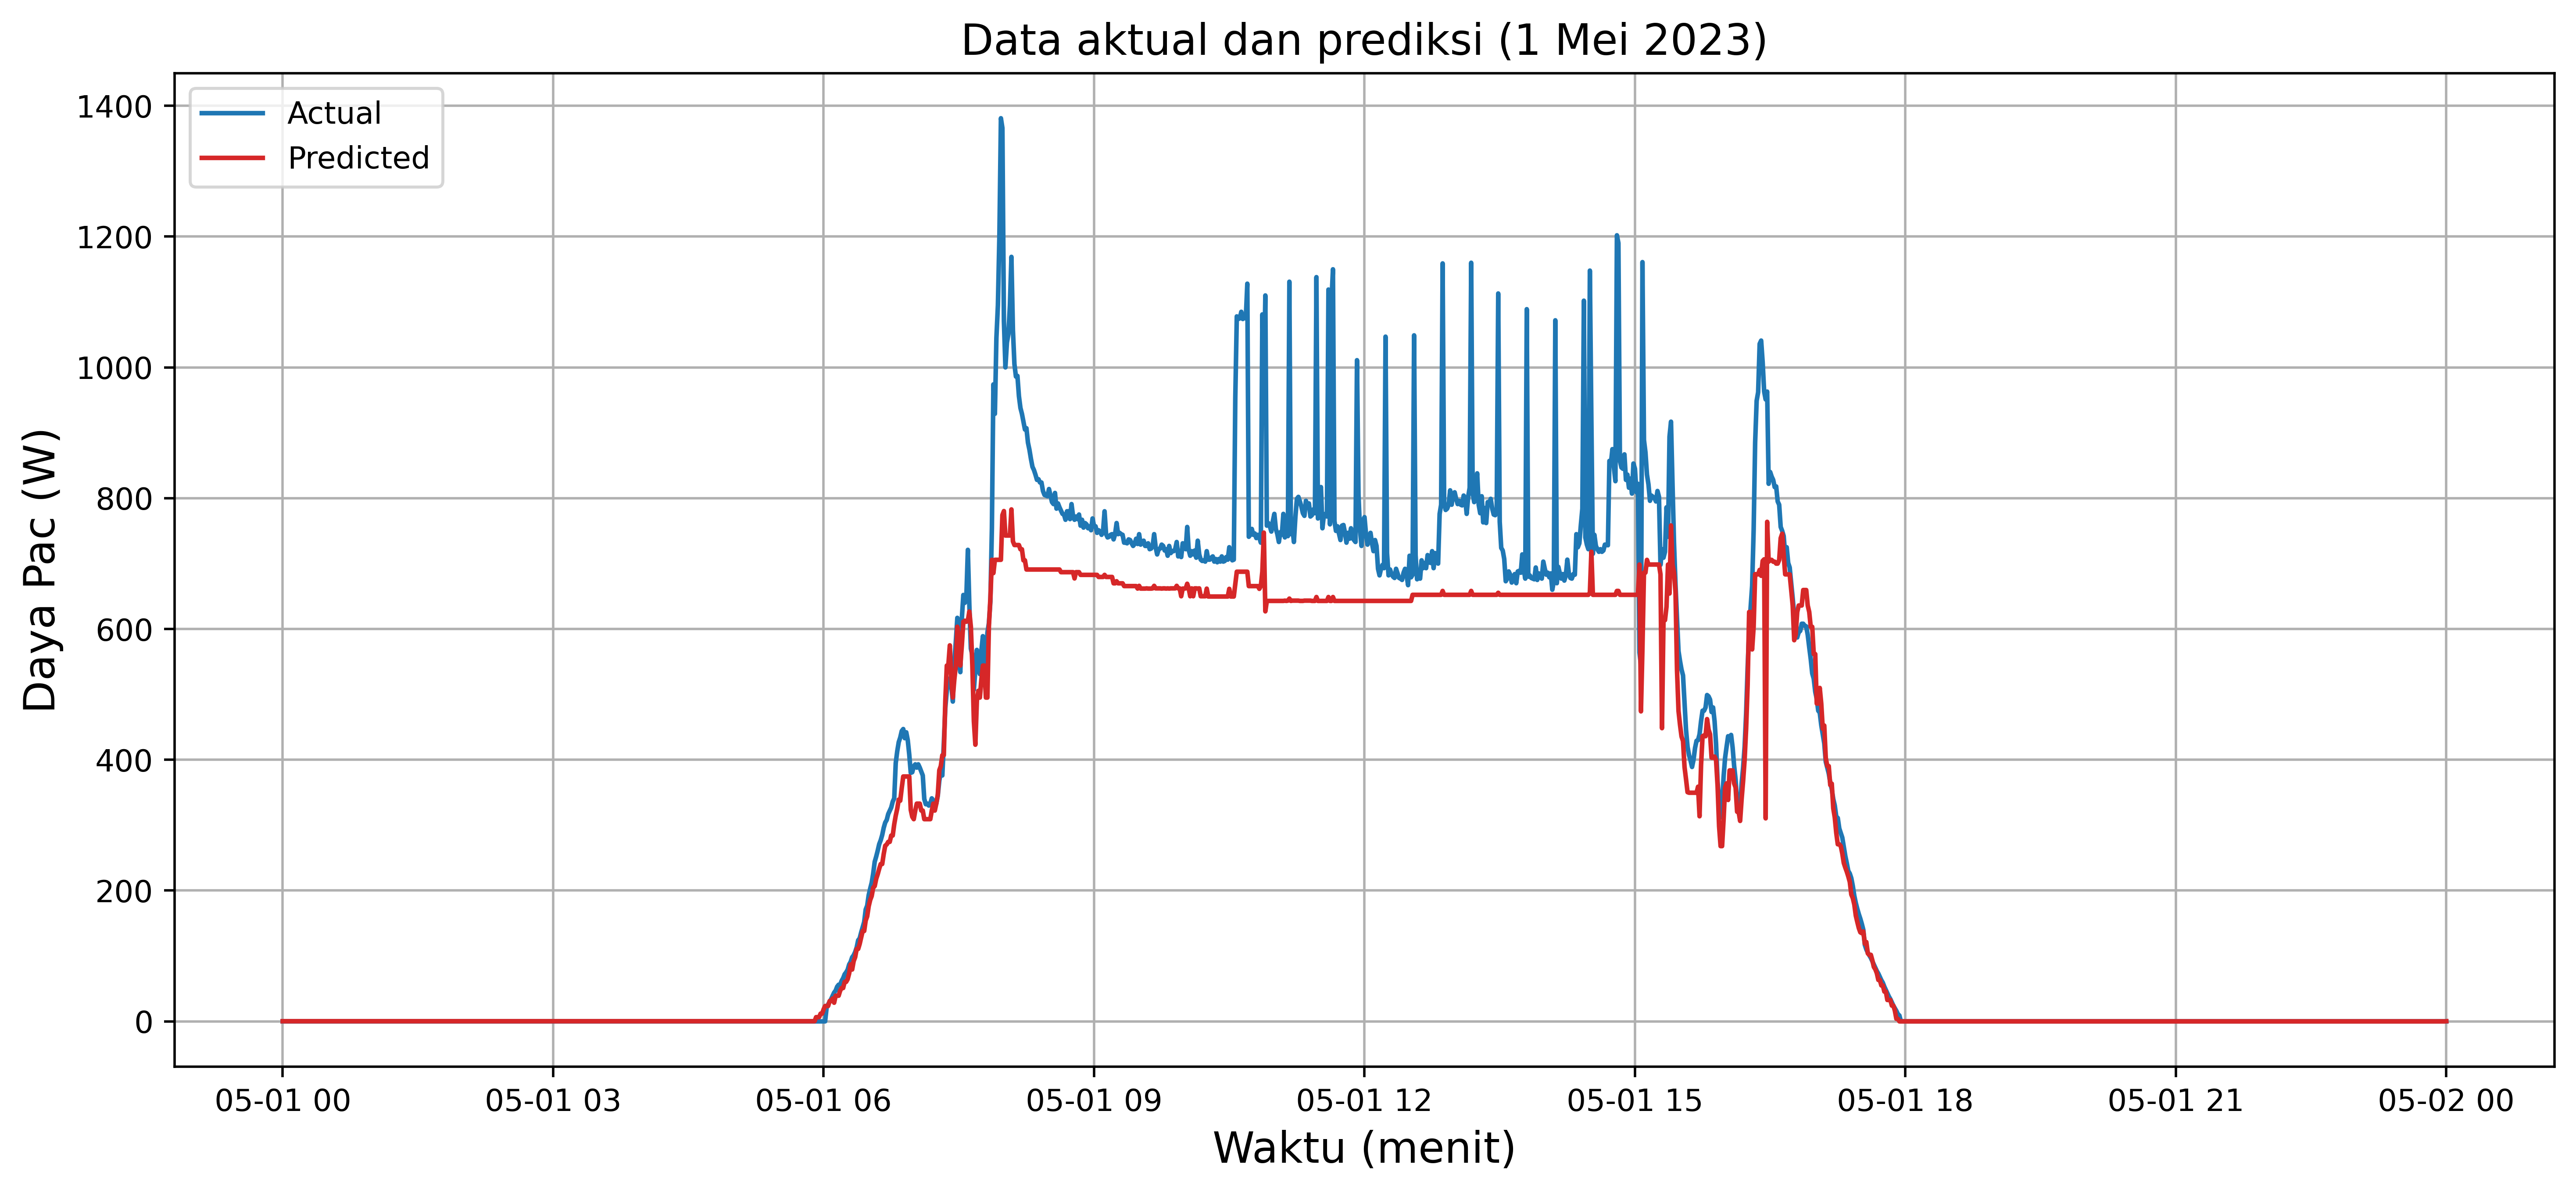

In [86]:
import matplotlib.pyplot as plt
import pandas as pd

# Konversi hasil prediksi menjadi DataFrame
y_pred_reg_df = pd.DataFrame(y_pred_reg, index=y_test_reg.index)

# Filter data hanya untuk rentang tanggal yang ditentukan
start_date = '2023-5-1'
end_date = '2023-5-2'
filtered_actual = y_test_reg[(y_test_reg.index >= start_date) & (y_test_reg.index <= end_date)]
filtered_predicted = y_pred_reg_df[(y_pred_reg_df.index >= start_date) & (y_pred_reg_df.index <= end_date)]

# Plot data aktual dan data yang diprediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

# Plot data aktual
ax.plot(filtered_actual.index, filtered_actual, label="Actual", color='tab:blue')

# Plot data yang diprediksi (misalnya, kolom pertama dari hasil prediksi)
ax.plot(filtered_predicted.index, filtered_predicted.iloc[:, 0], label="Predicted", color='tab:red')

# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (1 Mei 2023)", fontsize=14)
ax.grid()
# Menampilkan legenda
ax.legend(loc='upper left')
# Menyimpan plot ke file gambar
#plt.savefig('Model2a.png')

# Menampilkan plot
plt.show()


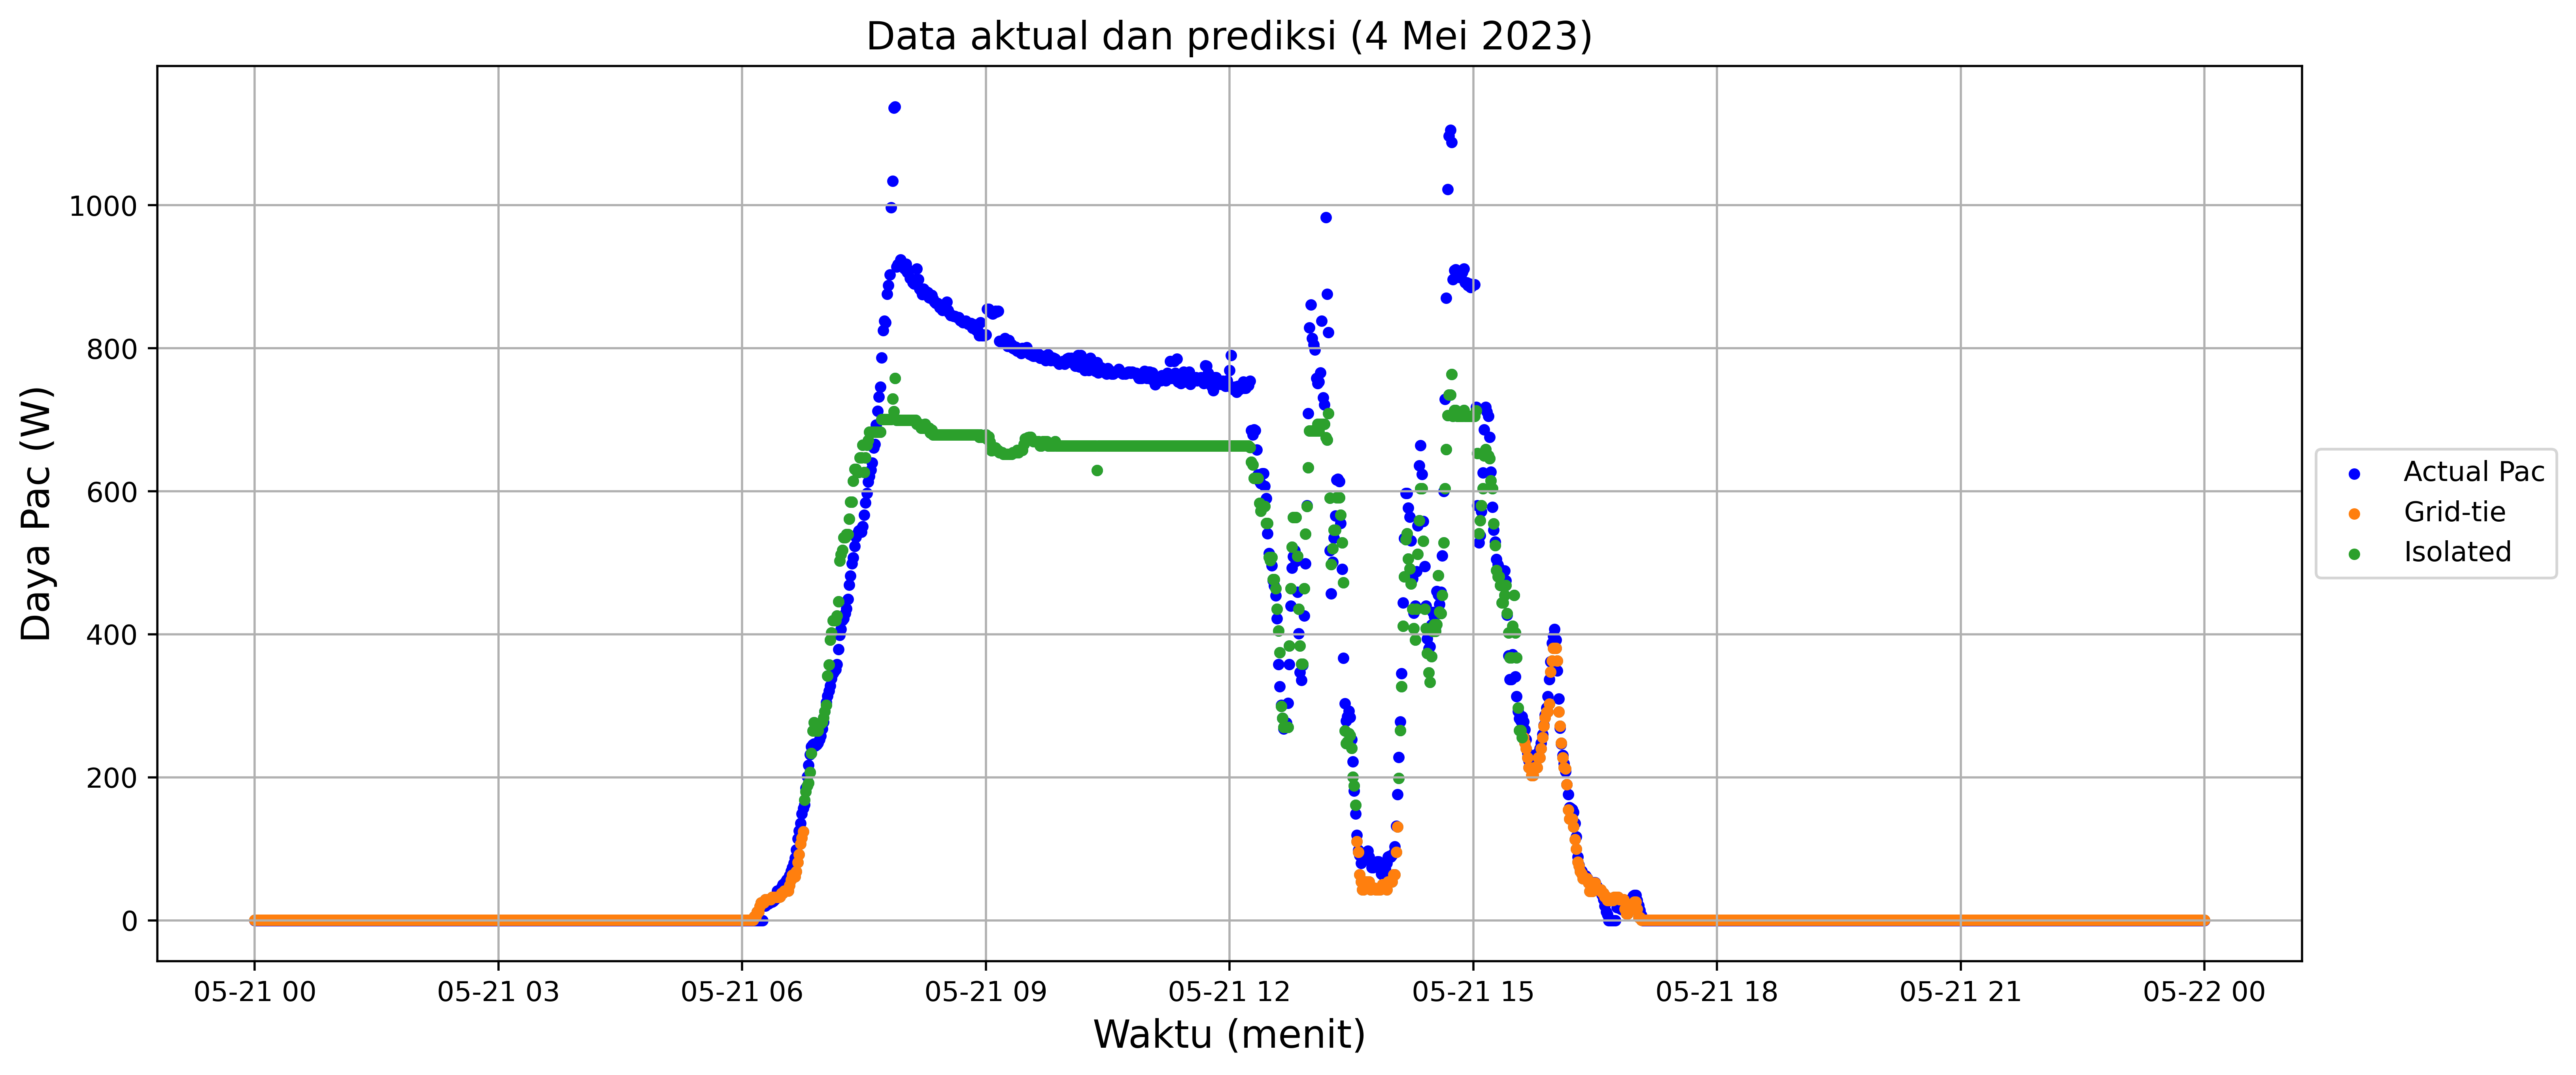

In [41]:
# Prediksi status operasi untuk setiap dataset (X_test_reg dan X_test_clf)
y_pred_clf = model_clf.predict(X_test_reg)

# Buat dataframe untuk menyimpan hasil prediksi
predictions_df = pd.DataFrame({
    'Timestamp': X_test_reg.index,  # Gunakan index sebagai timestamp
    'Actual_Pac': y_test_reg,  # Data aktual Pac
    'Predicted_Pac': y_pred_reg,  # Hasil prediksi Pac
    'Predicted_Status': y_pred_clf  # Hasil prediksi status operasi
})

# Pilih data hanya untuk satu bulan (misalnya, Oktober 2022)
start_date = '2023-5-21'
end_date = '2023-5-22'
filtered_data = predictions_df[(predictions_df['Timestamp'] >= start_date) & (predictions_df['Timestamp'] <= end_date)]

# Plot hasil prediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

# Scatter plot untuk Pac aktual
ax.scatter(filtered_data['Timestamp'], filtered_data['Actual_Pac'], label="Actual Pac", color='blue', s=10)

# Scatter plot untuk Pac yang diprediksi
ax.scatter(filtered_data['Timestamp'], filtered_data['Predicted_Pac'], s=10) #, label="Predicted Pac"

# Scatter plot untuk status operasi yang diprediksi
for status in filtered_data['Predicted_Status'].unique():
    status_data = filtered_data[filtered_data['Predicted_Status'] == status]
    label = "Grid-tie" if status == 0 else "Isolated"
    ax.scatter(status_data['Timestamp'], status_data['Predicted_Pac'], label=label, s=10)

# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (4 Mei 2023)", fontsize=14)
ax.grid()

# Menampilkan legenda
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Menyimpan plot ke file gambar
plt.savefig('Model2b.png')

# Menampilkan plot
plt.show()


In [58]:
import joblib
# Gabungkan model-regresi dan model-klasifikasi serta nama file model menjadi satu objek
combined_models = {
    'regression_model': model_custom_reg,
    'regression_model_file': 'regression_model.pkl',
    'classification_model': model_clf,
    'classification_model_file': 'classification_model.pkl'
}

# Simpan objek combined_models ke dalam file
joblib.dump(combined_models, 'Modelkondisi2baru.pkl')

['Modelkondisi2baru.pkl']

# Testing validasi data lain

In [59]:
#validasi

In [60]:
# Test set untuk regresi
X_validasi_reg2 = validasi.drop(columns=['Pac'])
y_validasi_reg2 = validasi['Pac']
# Test set untuk klasifikasi
X_validasi_clf2 = validasi.drop(columns=['Op_GriSwStt'])
y_validasi_clf2 = validasi['Op_GriSwStt']

In [61]:
df2_pred = model_custom_reg.predict(X_validasi_reg2)

In [62]:
# Evaluate regression model
mse_reg = mean_squared_error(y_validasi_reg2, df2_pred)
rmse_reg = np.sqrt(mse_reg)
R2_reg = r2_score(y_validasi_reg2, df2_pred)
MAE_reg = mean_absolute_error(y_validasi_reg2, df2_pred)
absolute_percentage_error_reg = np.abs((y_validasi_reg2 - df2_pred) / np.maximum(np.abs(y_validasi_reg2), 1)) * 100
mape_reg = np.mean(np.where(np.isfinite(absolute_percentage_error_reg), absolute_percentage_error_reg, 0))

print('Regression Model Metrics:')
print('Mean Squared Error on Test Set: ', mse_reg)
print('Root Mean Squared Error on Test Set: ', rmse_reg)
print('R2 Score on Test Set: ', r2_reg)
print('Mean Absolute Error on Test Set: ', MAE_reg)
print('Mean Absolute Percentage Error on Test Set: ', mape_reg, '%')
# Menghitung rata-rata dari data aktual dan hasil prediksi
actual_mean = np.mean
actual_mean = np.mean(y_validasi_reg2)
predicted_mean = np.mean(df2_pred)

# Menghitung bias
bias = actual_mean - predicted_mean

print('Rata-rata Actual:', actual_mean)
print('Rata-rata Predicted:', predicted_mean)
print('Bias:', bias)

Regression Model Metrics:
Mean Squared Error on Test Set:  44260.87541787711
Root Mean Squared Error on Test Set:  210.38268801847056
R2 Score on Test Set:  0.8618464525048616
Mean Absolute Error on Test Set:  96.65103036663459
Mean Absolute Percentage Error on Test Set:  141.99830231002758 %
Rata-rata Actual: 321.3753649095282
Rata-rata Predicted: 237.80870357708937
Bias: 83.5666613324388


In [63]:
# Filter hasil prediksi regresi yang negatif
negative_predictions_reg2 = df2_pred[df2_pred < 0]

# Print hasil prediksi regresi yang negatif
print("Hasil Prediksi Regresi yang Negatif:", negative_predictions_reg2)
# Hitung jumlah baris hasil prediksi regresi yang negatif
jumlah_baris_negatif_reg2 = negative_predictions_reg2.shape[0]

# Print jumlah baris hasil prediksi regresi yang negatif
print("Jumlah Baris dengan Hasil Prediksi Regresi yang Negatif:", jumlah_baris_negatif_reg2)


Hasil Prediksi Regresi yang Negatif: []
Jumlah Baris dengan Hasil Prediksi Regresi yang Negatif: 0


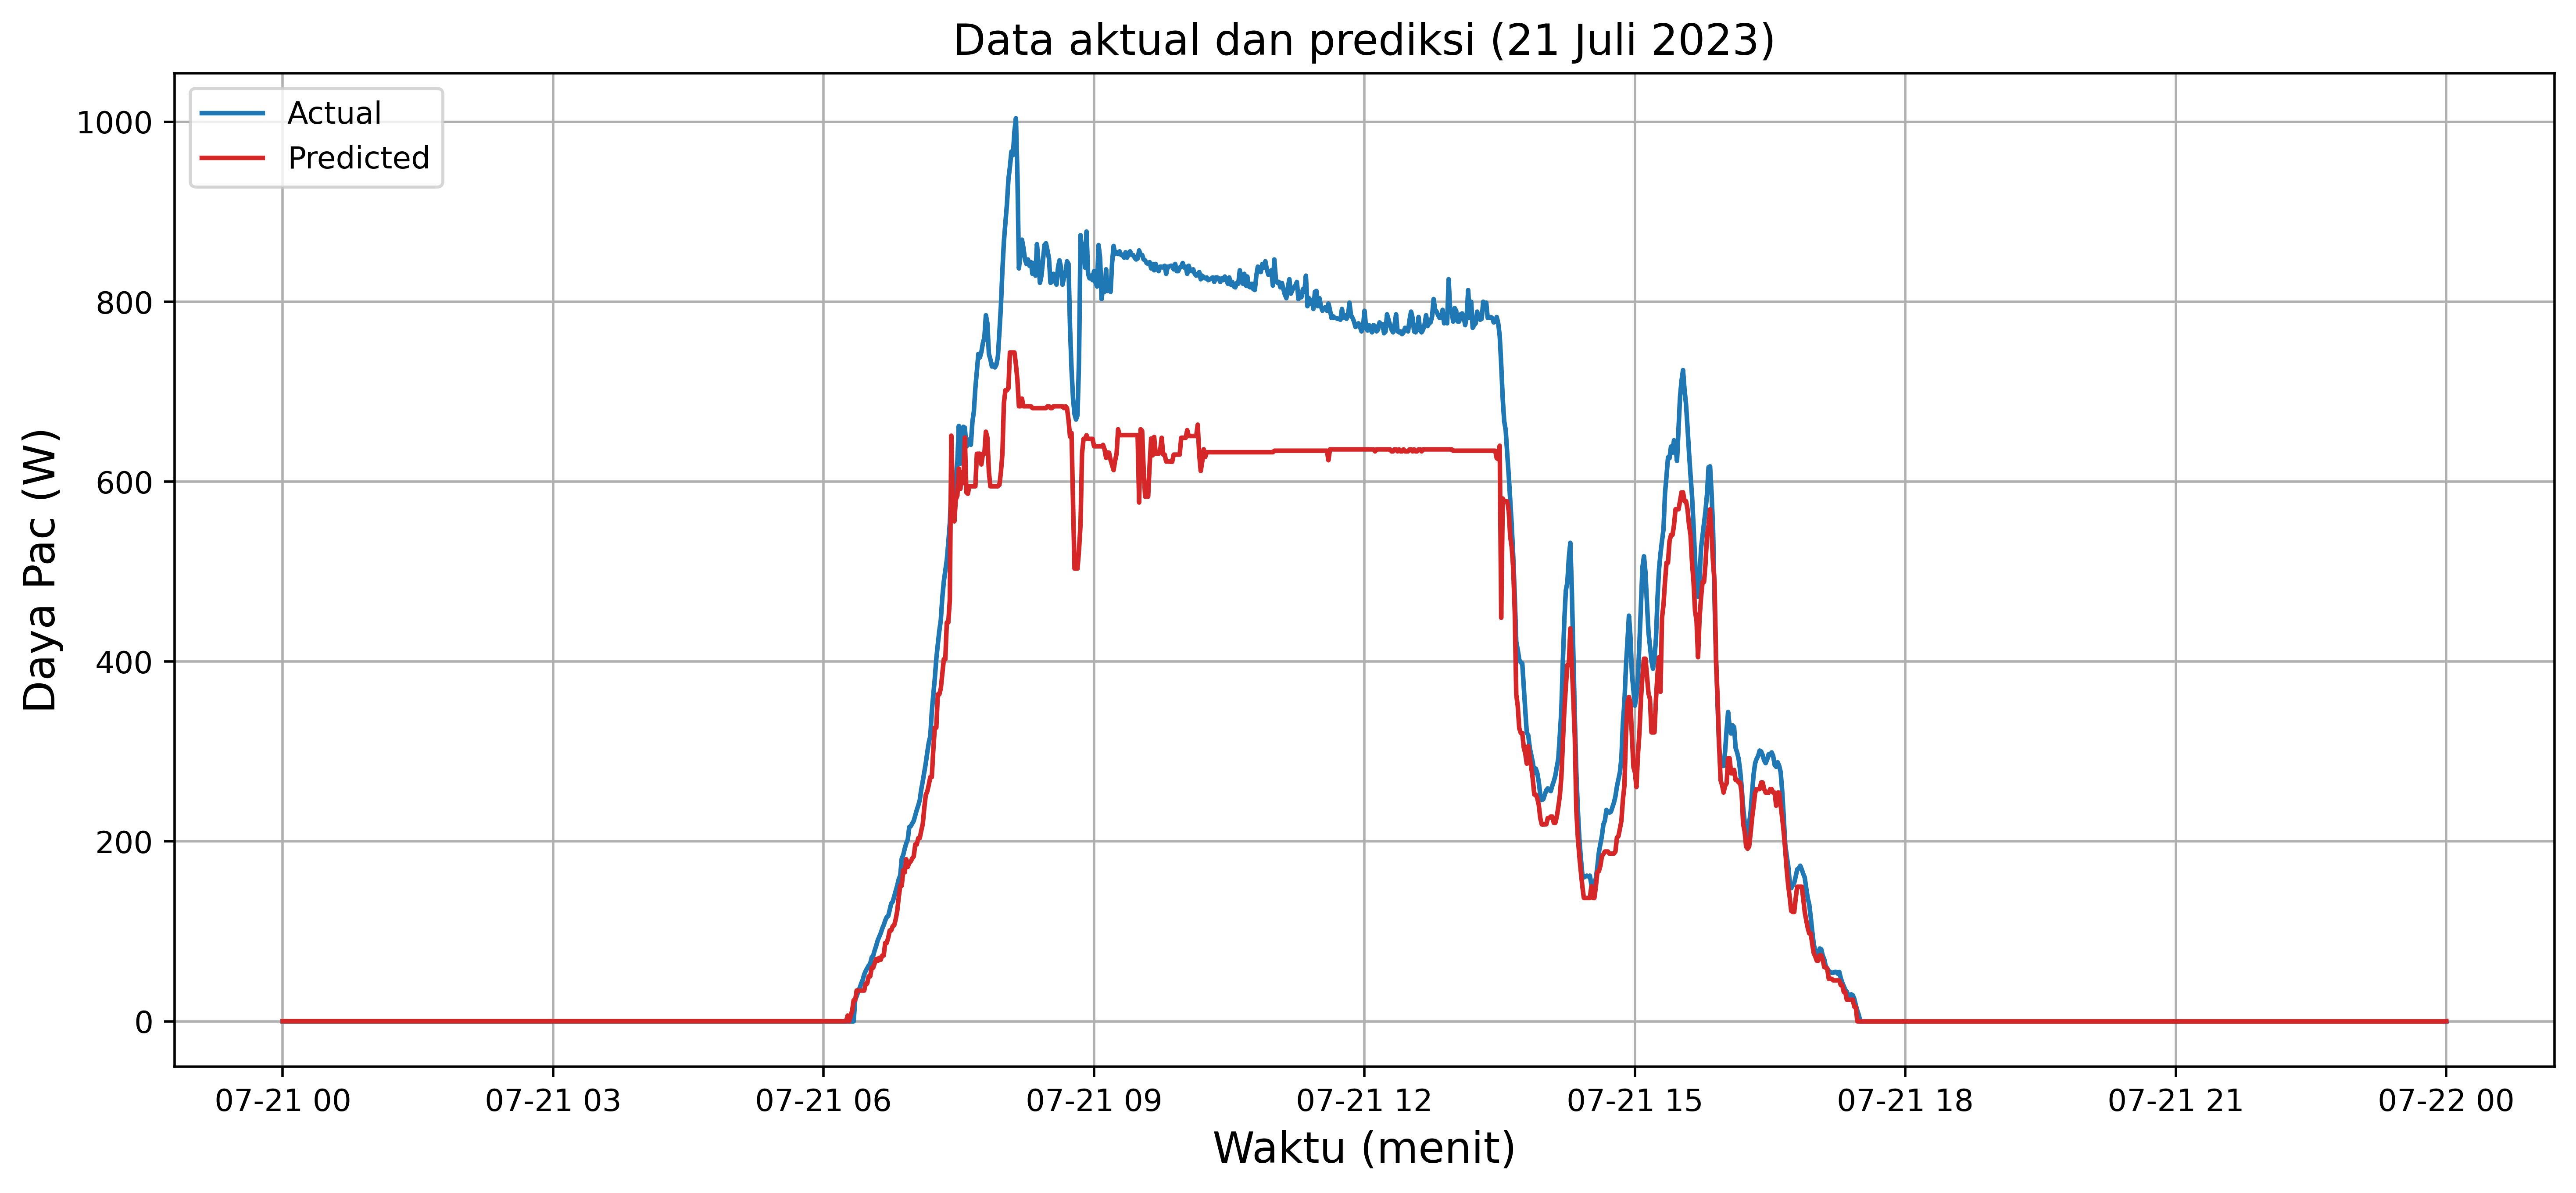

In [98]:
import matplotlib.pyplot as plt
import pandas as pd

# Konversi hasil prediksi menjadi DataFrame
y_pred_reg_df2 = pd.DataFrame(df2_pred, index=y_validasi_reg2.index)
# Filter data hanya untuk rentang tanggal yang ditentukan
start_date = '2023-7-21'
end_date = '2023-7-22'
filtered_actual2 = y_validasi_reg2[(y_validasi_reg2.index >= start_date) & (y_validasi_reg2.index <= end_date)]
filtered_predicted2 = y_pred_reg_df2[(y_pred_reg_df2.index >= start_date) & (y_pred_reg_df2.index <= end_date)]

# Plot data aktual dan data yang diprediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

# Plot data aktual
ax.plot(filtered_actual2.index, filtered_actual2, label="Actual", color='tab:blue')

# Plot data yang diprediksi (misalnya, kolom pertama dari hasil prediksi)
ax.plot(filtered_predicted2.index, filtered_predicted2.iloc[:, 0], label="Predicted", color='tab:red')

# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (21 Juli 2023)", fontsize=14)
ax.grid()

# Menampilkan legenda
ax.legend(loc='upper left')
# Menyimpan plot ke file gambar
plt.savefig('Model2c.png')

# Menampilkan plot
plt.show()


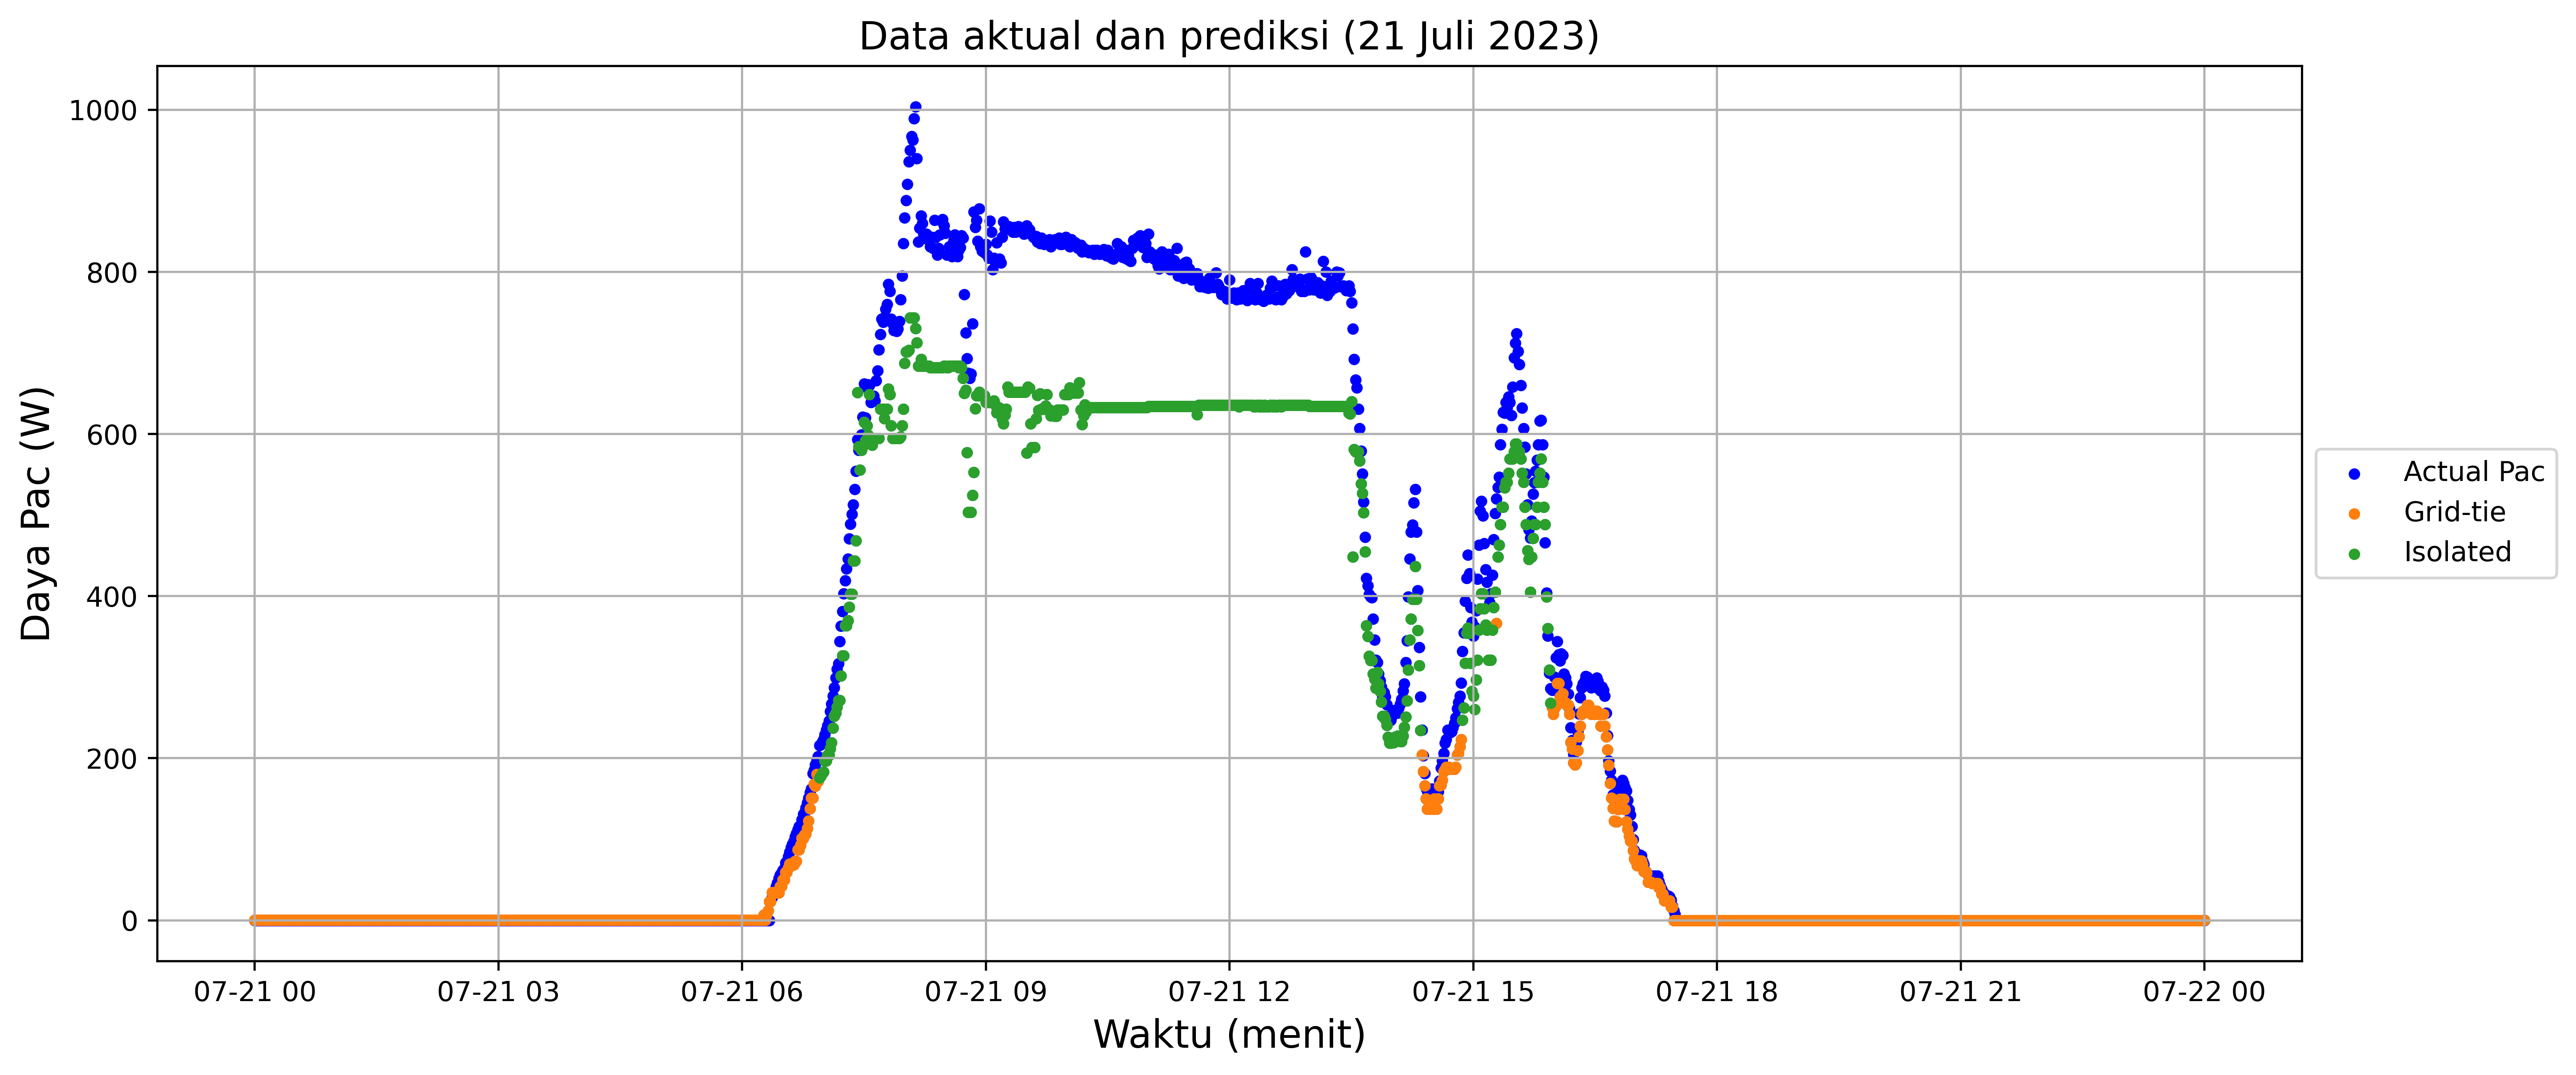

In [99]:
# Prediksi status operasi untuk setiap dataset (X_test_reg dan X_test_clf)
y_pred_clf2 = model_clf.predict(X_validasi_reg2)
# Buat dataframe untuk menyimpan hasil prediksi
predictions_df2 = pd.DataFrame({
    'Timestamp': X_validasi_reg2.index,  # Gunakan index sebagai timestamp
    'Actual_Pac': y_validasi_reg2,  # Data aktual Pac
    'Predicted_Pac': df2_pred,  # Hasil prediksi Pac
    'Predicted_Status': y_pred_clf2  # Hasil prediksi status operasi
})

# Pilih data hanya untuk satu bulan (misalnya, Oktober 2022)
start_date = '2023-7-21'
end_date = '2023-7-22'
filtered_data3 = predictions_df2[(predictions_df2['Timestamp'] >= start_date) & (predictions_df2['Timestamp'] <= end_date)]

# Plot hasil prediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

   
# Scatter plot untuk Pac aktual
ax.scatter(filtered_data3['Timestamp'], filtered_data3['Actual_Pac'], label="Actual Pac", color='blue', s=10)

# Scatter plot untuk Pac yang diprediksi
ax.scatter(filtered_data3['Timestamp'], filtered_data3['Predicted_Pac'], s=10) #, label="Predicted Pac"

# Scatter plot untuk status operasi yang diprediksi
for status in filtered_data3['Predicted_Status'].unique():
    status_data = filtered_data3[filtered_data3['Predicted_Status'] == status]
    label = "Grid-tie" if status == 0 else "Isolated"
    ax.scatter(status_data['Timestamp'], status_data['Predicted_Pac'], label=label, s=10)
    
# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (21 Juli 2023)", fontsize=14)
ax.grid()
# Menampilkan legenda
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Menyimpan plot ke file gambar
plt.savefig('Model2d.png')

# Menampilkan plot
plt.show()